In [2]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, utils
import random
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Data preprocessing and overview

### dictionary to label left and right

In [2]:
#left = 0, Right = 1, rule out = 2
dic_LR = {
          #TPE part
          'LVOT_Supravalvular_LCC':0,
          'LVOT_Supravalvular_RCC':0,
          'LVOT_Supravalvular_NCC':2,
          'LVOT_Supravalvular_LCC/RCCjunction':0,
          'LVOT_Infravalvular_AMC':0,
          'LVOT_Supravalvular_Septo-parahisian':0,
          'LVOT_Epicardial_AIV/CGV':0,
          'LV_MA':0,
          'LV_PPM_Anterolateral':0,
          'LV_PPM_Posteromedial':0,
          'LV_Crux':0,
          'LV_FascicularVT_Left_posterior_fascicle':0,
          'LV_FascicularVT_Left_anterior_fascicle':0,
          'LV_FascicularVT_Left_upper_septal_fascicle':0,
          'RVOT':1,
          'RV_Parahisian':1,
          'RV_TA':1,
          'RV_PA':1,
          'RV_PPM':1,
          #ZJ part
          'LCC':0,
          'AMC':0,
          'RCC':0,
          'LCC-RCC Ommisure':0,
          'Summit':0,
          'LC':1,
          'RVOTOther':1,
          'PosteriorSeptal':1,
          'AC':1,
          'FreeWall':1,
          'AnteriorSeptal':1,
          'RC':1
}

# Pytorch Data loader

In [3]:
class dataset_screen(Dataset):
    """VPC dataset"""
    def __init__(self, list_data , path_data_folder , dic_label, transform=None):
        """
        Args:
            path_data_folder: data.csv contain ecg signal and lable
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.list_data = list_data
        self.path_data_folder = path_data_folder
        self.transform = transform
        self.dic_label = dic_label
        
    def __len__(self):
        return len(self.list_data)
    def __getitem__(self, idx):
        
        file_name = self.list_data[idx]
        one_patient_dataframe = pd.read_csv(self.path_data_folder+'\\'+file_name,index_col=False)
        #filter out non-VPC data
        df_VPC = one_patient_dataframe[one_patient_dataframe['wave_type'] == 'VPC']
        str_location = df_VPC['location'].iloc[-1]
        #get list of segment id
        np_list_id = df_VPC['seg_id'].drop_duplicates().to_numpy()
        num_seg = len(np_list_id)
        list_len = []
        #screen through all seg
        for i in range(len(np_list_id)):
            id_seg = np_list_id[i]
            list_len.append(len(one_patient_dataframe[one_patient_dataframe['seg_id'] == id_seg].loc[:,'I':'V6'].index))
        #produce lable
        label = self.dic_label[str_location]
        #print(label,str_location)
        label = torch.tensor(label, dtype = torch.float)
        
        return (list_len , label , str_location, file_name)

In [3]:
#data loader get single wave from .csv file
class VPC_dataset(Dataset):
    """VPC dataset"""
    def __init__(self, list_data , path_data_folder , dic_label, transform=None):
        """
        Args:
            path_data_folder: data.csv contain ecg signal and lable
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.list_data = list_data
        self.path_data_folder = path_data_folder
        self.transform = transform
        self.dic_label = dic_label
        
    def __len__(self):
        return len(self.list_data)
    def __getitem__(self, idx):
        
        file_name = self.list_data[idx]
        one_patient_dataframe = pd.read_csv(self.path_data_folder+'\\'+file_name,index_col=False)
        str_location = one_patient_dataframe['location'].iloc[-1]

        #produce lable
        label = self.dic_label[str_location]
        label = torch.tensor(label, dtype = torch.long)
        ecg = one_patient_dataframe.loc[:,'I':'V6'].to_numpy()
        ecg = ecg.transpose()
        
        #transform data
        if self.transform:
            ecg = self.transform(ecg)  
        #expend one dim for training 
        ecg = ecg[None,:,:]
        
        return (ecg , label , str_location, file_name)

## Show ECG

In [4]:
#function to show 12 lead ecg all together, input format should be torch tensor
def plot1D_ecg(ecg,title):
    plt.figure(figsize=(20,5))
    for i in range(12):
        plt.subplot(1,12,i+1)
        plt.plot(ecg[i,:])
        plt.xlim([0,1000])
        plt.ylim([-10000,10000])
        plt.axis('off')
    plt.title(title)
    plt.show()
def plot2D_ecg(ecg,title):
    plt.figure(figsize=(5,2))
    plt.title(title)
    plt.imshow(ecg, aspect = 'auto' , interpolation = 'none')

## Data transformer
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [5]:
from skimage import io, transform
from scipy import interpolate

class Random_trimming(object): #randomly chopp off head or tail of an wave
    def __init__(self, max_trim):
        self.max_trim = max_trim #maximal trimming length
    def __call__(self, original_ecg):
        sig_len = np.shape(original_ecg)[1]
        drift = np.random.randint(-self.max_trim,self.max_trim,size = 1)[0]
        
        if drift >=0 :
            drift_result = original_ecg[:,0:sig_len-drift]
        else:
            drift_result = original_ecg[:,abs(drift):sig_len]
        return drift_result


class Add_edge_tail(object):
    
    def __init__(self, sig_len):
        self.sig_len = sig_len
        
    def __call__(self, original_ecg):
        original_len = np.shape(original_ecg)[1]
        #print(np.shape(original_ecg))
        if original_len <= self.sig_len:
            #add zero to signal tail to make the signal into equal length(sig_len), clip the tail if it is too long
            pad_result = np.pad(original_ecg ,((0,0),(0,self.sig_len-original_len)),'edge')
            return pad_result
        else:
            return original_ecg[:,0:self.sig_len]
class Random_drift(object):

    def __init__(self, max_drift):
        self.max_drift = max_drift
        
    def __call__(self, ecg):
        original_len = np.shape(ecg)[1]
        low = -self.max_drift
        high = self.max_drift
        drift = int(np.random.uniform(low,high,1))
        if drift>=0:
            #extend head if drift to right
            drift_result = np.pad(ecg ,( (0,0),  (    0      , abs(drift) )) , 'edge' )
            
            return drift_result
        else:
            #extend head if drift to left
            drift_result = np.pad(ecg ,( (0,0),  (abs(drift) ,      0      )) , 'edge' )
            return drift_result
                                  
class Random_strech(object): # strech the wave to the targe wave length
    def __init__(self,strech_range):
        self.strech_range = strech_range
    def __call__(self, ecg):
        original_len = np.shape(ecg)[1]
        low = self.strech_range[0]
        high = self.strech_range[1]
        target = int(np.random.uniform(low,high,1)[0]*original_len)
        ecg_new = np.zeros((12,target))
        for i in range(12):
            y = ecg[i,:]
            x = np.linspace(0, 1, num = original_len)
            x_new = np.linspace(0, 1, num = target)
            y_new = np.interp(x_new, x, y)
            ecg_new[i,:]=y_new
        return ecg_new
class Strech_to_target(object):
    def __init__(self,target):
        self.target = target
    def __call__(self, ecg):
        ecg_new = np.zeros((12,self.target))
        for i in range(12):
            y = ecg[i,:]
            original_len = np.shape(y)[0]
            x = np.linspace(0, 1, num = original_len)
            x_new = np.linspace(0, 1, num = self.target)
            y_new = np.interp(x_new, x, y)
            ecg_new[i,:]=y_new
        return ecg_new
    
class Random_vertical_drift_tilt(object):#randomly vertical drift ecg leads
    def __init__(self,max_drift,max_tilt):
        self.max_drift = max_drift
        self.max_tilt = max_tilt
    def __call__(self,ecg):
        original_len = np.shape(ecg)[1]
        #random vertical drift
        max_drift = self.max_drift
        drift = np.random.uniform(-max_drift,max_drift,12)
        drift = np.expand_dims(drift, axis=1)
        drift = np.pad(drift,( (0,0) , (0,original_len-1)) ,'edge')
        #random tilt
        max_tilt = self.max_tilt
        tilt = np.random.uniform(-max_tilt,max_tilt,12)
        tilt_matrix = np.transpose(np.linspace(0, tilt, num = original_len))
        
        drift_result = ecg+drift+tilt_matrix
        return drift_result
    
class Random_scale:   # randomly scale individual signal of 12 lead ecg or randomly scale up all leads
    def __init__(self,scale_range_single, scale_range_all):
        self.scale_range_single = scale_range_single
        self.scale_range_all = scale_range_all
    def __call__(self,ecg):
        original_len = np.shape(ecg)[1]
        #scale individual lead signal differently
        scale_range_single = self.scale_range_single
        low_single = scale_range_single[0]
        high_single = scale_range_single[1]
        scale_list = np.random.uniform(low_single,high_single,(12,1))
        scale = np.broadcast_to(scale_list, (12, original_len))
        
        #scale all lead with equal ratio
        scale_range_all = self.scale_range_all 
        low_all = scale_range_all[0]
        high_all = scale_range_all[1]
        scale_all = np.random.uniform(low_all,high_all,1)
        scale = np.multiply(scale,scale_all)
        return np.multiply(ecg,scale)
class Add_noise(object): #add random value to all signal
    def __init__(self,max_noise):
        self.max_noise = max_noise
    def __call__(self,ecg):
        max_noise = self.max_noise
        original_len = np.shape(ecg)[1]
        random_noise = np.random.uniform(-max_noise,max_noise,(12,original_len))
        return ecg+random_noise

class To_torch_tensor(object):
    def __call__(self, np_ecg):
        return torch.tensor(np_ecg, dtype = torch.float)


In [6]:
import time
for x in range (0,5):  
    b = "Loading" + "." * x
    print (b, end="\r")
    time.sleep(1)

### test data transformation

In [7]:
path_data = 'E:\\back up2\\Google Drive\\Large Files\\Datasets\\VT_datasets\\VPC2\\test'
list_file = os.listdir(path_data)
data_transform = transforms.Compose([
#         Random_trimming(100),
#         Random_strech([0.8,1.2]),
         #Random_drift(200),
#          Random_scale([1,1],[0.1,0.1]),
         Add_edge_tail(1024),
        #Random_vertical_drift_tilt(0,10000),
        #Add_noise(1000),
        To_torch_tensor(),
    ])
#data transformation
train_data_loader = VPC_dataset( list_file , path_data , dic_LR , transform = data_transform )

torch.Size([1, 12, 1024])


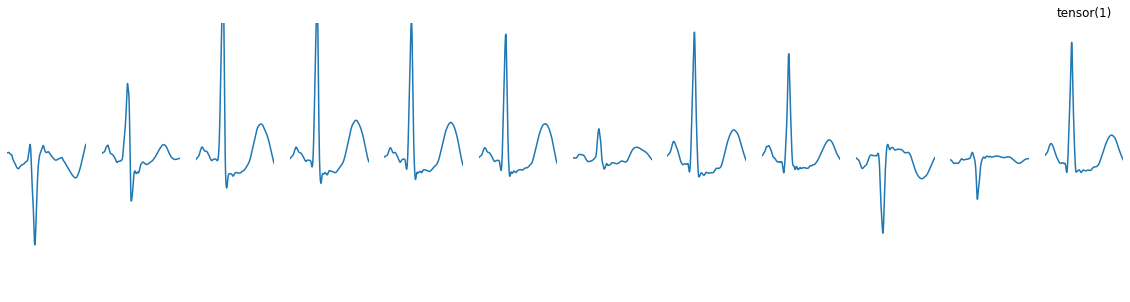

In [7]:
ecg , label , str_location, file_name = train_data_loader[1]
print(ecg.size())
plot1D_ecg(ecg[0,:,:],label)


In [403]:
path_data_TPE = 'C:\\Users\\USER\\Desktop\\VPC\\TPE_only'
list_full_file_TPE = os.listdir(path_data_TPE)
data_transform_TPE = transforms.Compose([
#         Random_trimming(100),
#         Random_strech([0.8,1.2]),
         #Random_drift(200),
         Add_edge_tail(1024),
        #Random_vertical_drift_tilt(0,10000),
        #Add_noise(1000),
        #Random_scale([0.01,10]),
        To_torch_tensor()
    ])
#data transformation
train_data_loader_TPE = VPC_dataset( list_full_file_TPE , path_data_TPE , dic_LR , transform = data_transform_TPE )

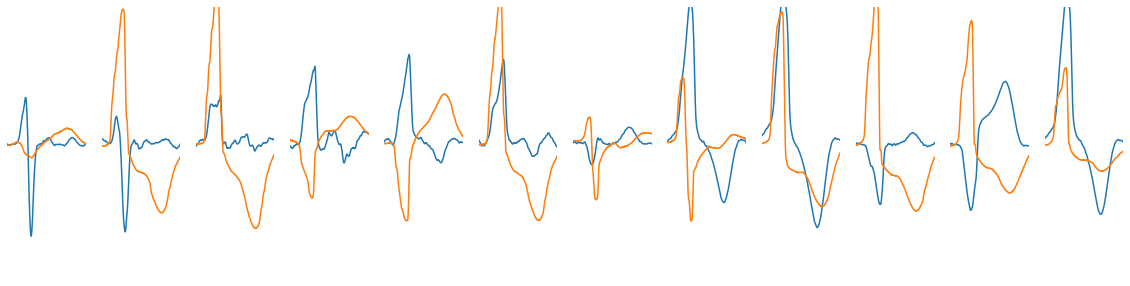

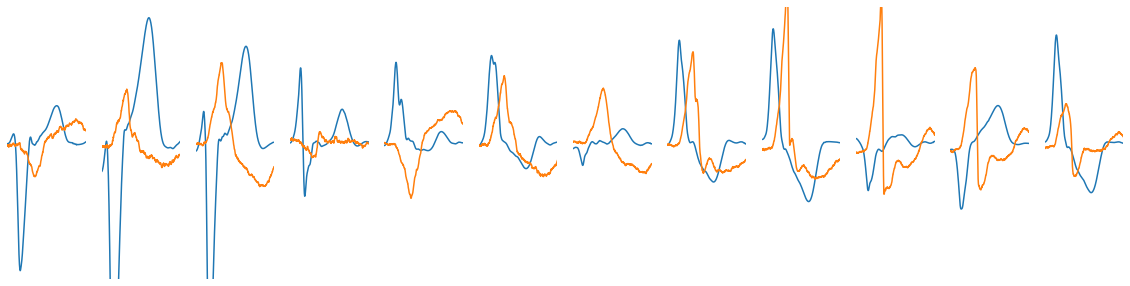

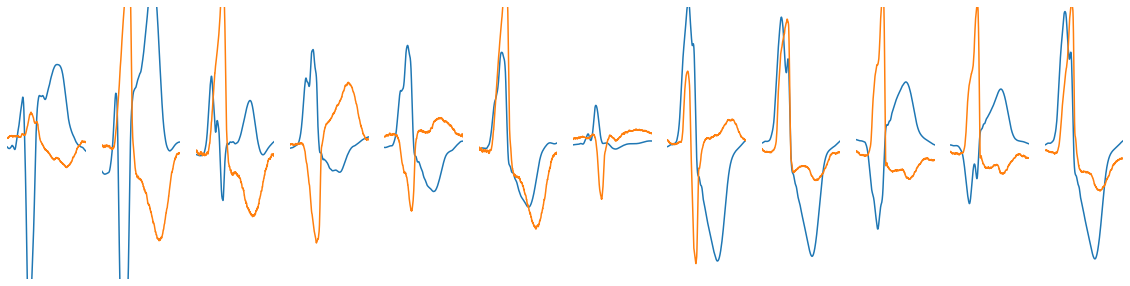

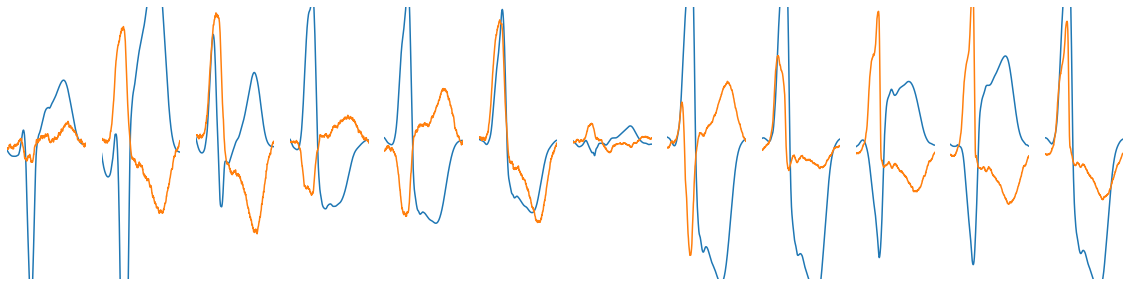

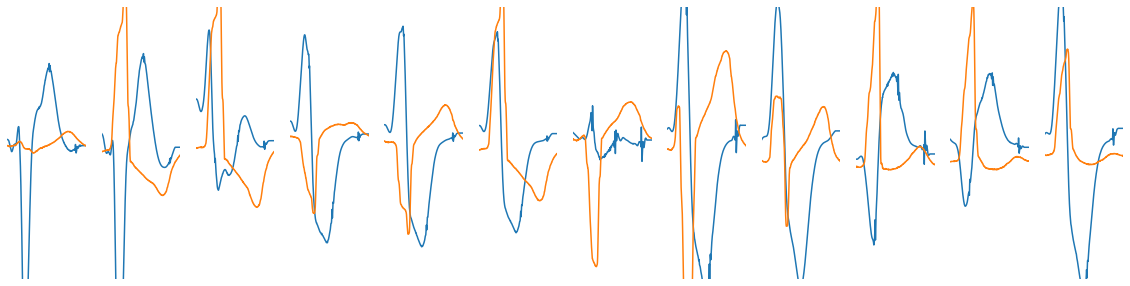

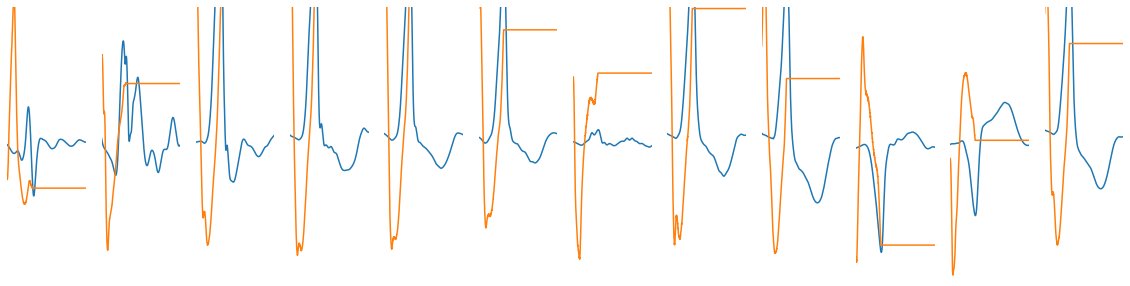

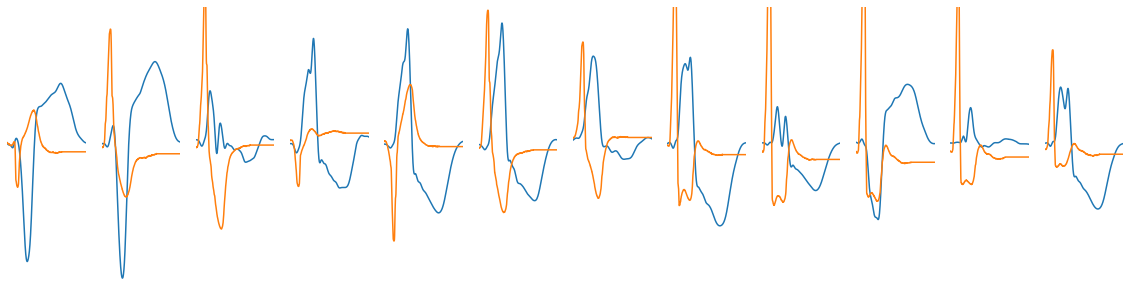

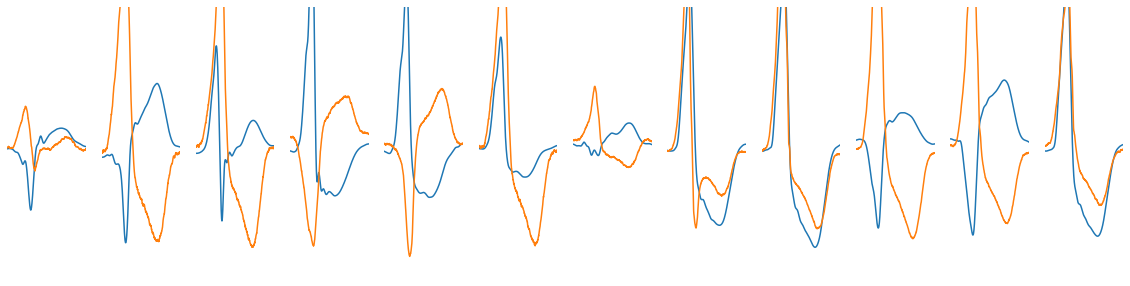

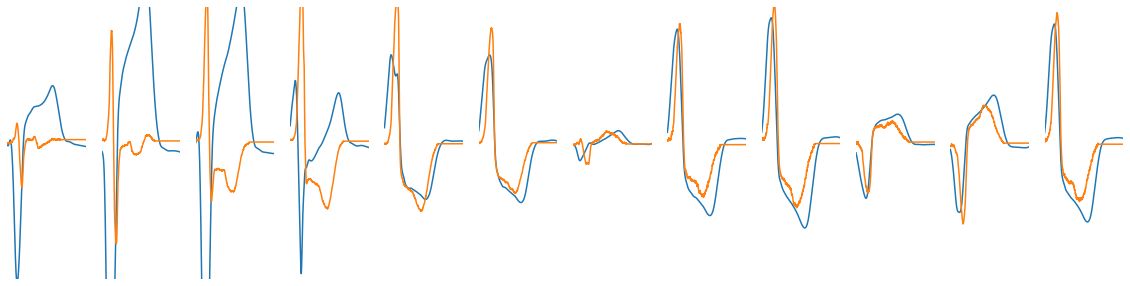

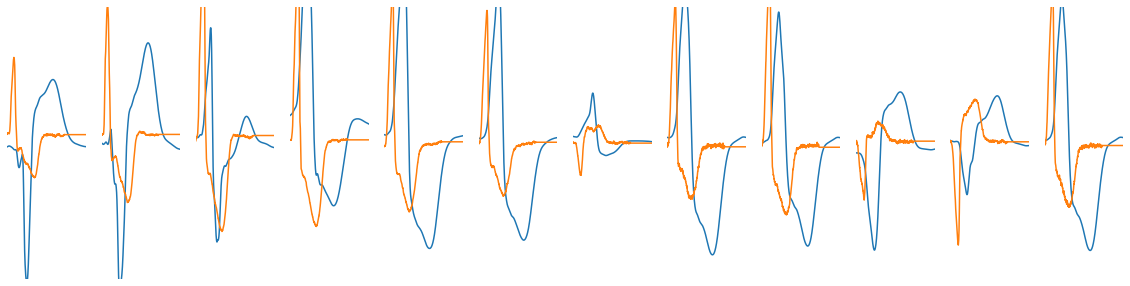

In [413]:
for i in range(10):
    torch_ecg_ZJ, label, str_location, file_name = train_data_loader[i]
    torch_ecg_TPE, label, str_location, file_name = train_data_loader_TPE[i]
    ecg_ZJ = torch_ecg_ZJ[0,:,:]
    ecg_TPE = torch_ecg_TPE[0,:,:]
    plt.figure(figsize=(20,5))
    for i in range(12):
        plt.subplot(1,12,i+1)
        plt.plot(ecg_ZJ[i,:])
        plt.plot(2*ecg_TPE[i,:])
        plt.xlim([0,1000])
        plt.ylim([-20000,20000])
        plt.axis('off')
    plt.show()


### CNN model for left and right

In [6]:
#set up model
import torch.nn as nn
import torch.nn.functional as F
# Create CNN Model
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        #=========== Horizontal CNN===========
        # first CNN
        # H0 output 12x1024
        self.cnn_H0 = nn.Conv2d(in_channels=1, out_channels = 16, kernel_size=(1,129), stride=1, padding=(0,64)) #output_shape=(16,12,1024) 
        self.dropout_H0 = nn.Dropout(0.1)
        self.act_H0 = nn.ReLU() # activation
        
        # H1_1 output 16x12x1024
        self.cnn_H1_1 = nn.Conv2d(in_channels=16, out_channels = 16, kernel_size=(1,129), stride=1, padding=(0,64)) #output_shape=(16,12,1024) 
        self.dropout_H1_1 = nn.Dropout(0.1)
        self.act_H1_1 = nn.ReLU() # activation
       
        # bach norm
        self.bactN_H1 = nn.BatchNorm2d(16)
        # pool
        self.pool_H1 = nn.AvgPool2d(kernel_size=(1,2)) #16x12x1024 --> 16x12x512
        
        # H2_1 output 32x12x512
        self.cnn_H2_1 = nn.Conv2d(in_channels=16, out_channels = 32, kernel_size=(1,65), stride=1, padding=(0,32)) #output_shape=(16,12,1024) 
        self.dropout_H2_1 = nn.Dropout(0.1)
        self.act_H2_1 = nn.ReLU() # activation
      
        # bach norm
        self.bactN_H2 = nn.BatchNorm2d(32)
        #  pool 
        self.pool_H2 = nn.AvgPool2d(kernel_size=(1,2))  #32x12x512 --> 32x12x256
        
        # H3_1 output 64x12x256
        self.cnn_H3_1 = nn.Conv2d(in_channels=32, out_channels = 64, kernel_size=(1,33), stride=1, padding=(0,16)) #output_shape=(16,12,1024) 
        self.dropout_H3_1 = nn.Dropout(0.1)
        self.act_H3_1 = nn.ReLU() # activation
        
        
        # bach norm
        self.bactN_H3 = nn.BatchNorm2d(64)
        #  pool 
        self.pool_H3 = nn.AvgPool2d(kernel_size=(1,2)) #64x12x256 --> 64x12x128
        
        #=========== Vertical CNN===========
        
        # V0 output 64x1x128
        self.cnn_V0 = nn.Conv2d(in_channels=64, out_channels = 128, kernel_size=(12,1), stride=1, padding=(0,0)) #output_shape=(16,12,1024) 
        self.dropout_V0 = nn.Dropout(0.1)
        self.act_V0 = nn.ReLU() # activation
        
        # V1 
        self.cnn_V1_1 = nn.Conv2d(in_channels=128, out_channels = 128, kernel_size=(1,3), stride=1, padding=(0,1)) #output_shape=(16,12,1024) 
        self.dropout_V1_1 = nn.Dropout(0.1)
        self.act_V1_1 = nn.ReLU() # activation
        
        # bach norm
        self.bactN_V1 = nn.BatchNorm2d(128)
        #  pool 
        self.pool_V1 = nn.AvgPool2d(kernel_size=(1,2)) 
        
        #===========Fully connected layer========
        # Fully connected 1 
        self.fc1 = nn.Linear(128*1*64,1024)
        self.dropout_fc1 = nn.Dropout(0.1)
        self.actFC1 = nn.ReLU()# activation
        # Fully connected 2 with relu
        self.fc2 = nn.Linear(1024,1024)
        self.dropout_fc2 = nn.Dropout(0.1)
        self.actFC2 = nn.ReLU()# activation
        # Fully connected 3 with relu
        self.fc3 = nn.Linear(1024,1)
        self.output = nn.Sigmoid()
    
        #weight initialization
        self.initialize_weights()
        
    def forward(self, x):
        #horizontal cnn
        out = self.cnn_H0(x) 
        out = self.dropout_H0(out) 
        out = self.act_H0(out)
        
        out = self.cnn_H1_1(out)
        out = self.dropout_H1_1(out)
        out = self.act_H1_1(out)
        
        out = self.pool_H1(out)
        out = self.bactN_H1(out)
        
        out = self.cnn_H2_1(out)
        out = self.dropout_H2_1(out) 
        out = self.act_H2_1(out)
        
        out = self.bactN_H2(out)
        out = self.pool_H2(out)
        
        out = self.cnn_H3_1(out)
        out = self.dropout_H3_1(out) 
        out = self.act_H3_1(out)
        
        out = self.bactN_H3(out)
        out = self.pool_H3(out)
        
        out = self.cnn_V0(out)
        out = self.dropout_V0(out) 
        out = self.act_V0(out)
        
        out = self.cnn_V1_1(out) 
        out = self.dropout_V1_1(out)
        out = self.act_V1_1(out)
        
        out = self.bactN_V1(out)
        out = self.pool_V1(out)
        #print(np.shape(out))
        out = torch.flatten(out,1)
        
        out = self.fc1(out)   #fully connected 1
        out = self.dropout_fc1(out)
        out = self.actFC1(out)
        out = self.fc2(out)   #fully connected 2
        out = self.dropout_fc2(out)
        out = self.actFC2(out)
        out = self.fc3(out)   #fully connected 3
        out = self.output(out)
        return out
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m,nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight,nonlinearity='relu')
                print(m)
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias,0)
            elif isinstance(m,nn.Linear):
                nn.init.kaiming_uniform_(m.weight,nonlinearity='relu')
                print(m)
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias,0)

model = CNN_Model()
from torchsummary import summary
summary(model.cuda(), (1, 12, 1024))

Conv2d(1, 16, kernel_size=(1, 129), stride=(1, 1), padding=(0, 64))
Conv2d(16, 16, kernel_size=(1, 129), stride=(1, 1), padding=(0, 64))
Conv2d(16, 32, kernel_size=(1, 65), stride=(1, 1), padding=(0, 32))
Conv2d(32, 64, kernel_size=(1, 33), stride=(1, 1), padding=(0, 16))
Conv2d(64, 128, kernel_size=(12, 1), stride=(1, 1))
Conv2d(128, 128, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
Linear(in_features=8192, out_features=1024, bias=True)
Linear(in_features=1024, out_features=1024, bias=True)
Linear(in_features=1024, out_features=1, bias=True)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 12, 1024]           2,080
           Dropout-2         [-1, 16, 12, 1024]               0
              ReLU-3         [-1, 16, 12, 1024]               0
            Conv2d-4         [-1, 16, 12, 1024]          33,040
           Dropout-5         [-1, 16, 12, 1024]             

In [454]:
#https://discuss.pytorch.org/t/how-to-replace-all-relu-activations-in-a-pretrained-network/31591
#shift relu to LeakyReLU
for i, (name, layer) in enumerate(model.named_modules()):
    if isinstance(layer, nn.ReLU):
        setattr(model, name, nn.ELU())
        print(name)

act_H0
act_H1
act_H2_1
act_H3_1
act_V0
act_V1_1
actFC1
actFC2


In [455]:
from torchsummary import summary
summary(model.cuda(), (1, 12, 1024))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 12, 1024]           2,080
           Dropout-2         [-1, 16, 12, 1024]               0
               ELU-3         [-1, 16, 12, 1024]               0
            Conv2d-4         [-1, 16, 12, 1024]          33,040
       BatchNorm2d-5         [-1, 16, 12, 1024]              32
           Dropout-6         [-1, 16, 12, 1024]               0
         AvgPool2d-7          [-1, 16, 12, 512]               0
            Conv2d-8          [-1, 32, 12, 512]          33,312
           Dropout-9          [-1, 32, 12, 512]               0
              ELU-10          [-1, 32, 12, 512]               0
      BatchNorm2d-11          [-1, 32, 12, 512]              64
        AvgPool2d-12          [-1, 32, 12, 256]               0
           Conv2d-13          [-1, 64, 12, 256]          67,648
          Dropout-14          [-1, 64, 

# Load existing model

In [273]:
model.load_state_dict(torch.load('E:\\back up2\\Google Drive\\Large Files\\Datasets\\VT_datasets\\models\\model_CNN_LR_v5.pth'))
model.eval()

CNN_Model(
  (cnn_H0): Conv2d(1, 16, kernel_size=(1, 129), stride=(1, 1), padding=(0, 64))
  (dropout_H0): Dropout(p=0.0, inplace=False)
  (act_H0): ReLU()
  (cnn_H1_1): Conv2d(16, 16, kernel_size=(1, 129), stride=(1, 1), padding=(0, 64))
  (dropout_H1_1): Dropout(p=0.0, inplace=False)
  (act_H1_1): ReLU()
  (bactN_H1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool_H1): AvgPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0)
  (cnn_H2_1): Conv2d(16, 32, kernel_size=(1, 65), stride=(1, 1), padding=(0, 32))
  (dropout_H2_1): Dropout(p=0.0, inplace=False)
  (act_H2_1): ReLU()
  (bactN_H2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool_H2): AvgPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0)
  (cnn_H3_1): Conv2d(32, 64, kernel_size=(1, 33), stride=(1, 1), padding=(0, 16))
  (dropout_H3_1): Dropout(p=0.0, inplace=False)
  (act_H3_1): ReLU()
  (bactN_H3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

# Train model
<hr>

# Build model
<hr>
links for CNN 2D prediction
general tutorial
* https://hackmd.io/@lido2370/S1aX6e1nN?type=view
* https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
* https://www.kaggle.com/basu369victor/pytorch-tutorial-the-classification
* https://www.pluralsight.com/guides/image-classification-with-pytorch
initialization
* https://www.youtube.com/watch?v=xWQ-p_o0Uik
* https://pytorch.org/docs/stable/nn.init.html

### Function to screen out VPC, VT or Sinus file list for further data loading

In [267]:
#function to rule out file only had VT, but no VPC
def get_file_VPC(path_folder):
    list_file_name = os.listdir(path_folder)
    list_target_file = []
    for i in range(len(list_file_name)):
        file_name = list_file_name[i] 
        wave_type = file_name.split('_')[0]
        if wave_type == 'VPC' :
            list_target_file.append(file_name)
#         elif wave_type == 'VT':
#             count_VT+=1
#             print(count_VT)
    return list_target_file


#function to screen out wave base on label 
def get_file_Location(path_folder,list_file_name,dic_label):
    list_ID = []
    for i in range(len(list_file_name)):
        file_name = list_file_name[i]
        one_patient_dataframe = pd.read_csv(path_folder+'\\'+file_name,index_col=False)
        str_location = one_patient_dataframe['location'].iloc[-1] 
        ID = one_patient_dataframe['ID'].iloc[-1]
        #produce lable
        label = dic_label[str_location]
        #if the wave contain target label and the name had not been registered
        if ((label == 0) | (label == 1)) and (ID not in list_ID) :
            print(ID,label)
            list_ID.append(ID)
    return list_ID


import random

#function to randomly split file base on ID
def random_file_split(train_ratio, list_ID):
    random.shuffle(list_ID)
    len_file = len(list_ID)
    len_train = int(len_file*train_ratio)
    len_validation = len_file-len_train
    list_train = list_ID[ 0 : len_train ]
    list_validation = list_ID[ len_train : len_file ]
    return list_train,list_validation

#function to gather waves containing target ID
def gather_waves(list_ID, source_list, path_folder):
    full_file_name_list = []
    for i in range(len(source_list)):
        file_name = source_list[i]
        one_patient_dataframe = pd.read_csv(path_folder+'\\'+file_name,index_col=False)
        ID = one_patient_dataframe['ID'].iloc[-1]
        if ID in list_ID:
            print(file_name)
            full_file_name_list.append(file_name)
    return full_file_name_list

#weighted sample base on different location
def weighted_sampling(list_source,path_folder , df_weight):
    list_pool = [] #list of pool for sampling
    for i in range(len(list_source)):
        file_name = list_source[i]
        one_patient_dataframe = pd.read_csv(path_folder+'\\'+file_name,index_col=False)
        str_location = one_patient_dataframe['location'].iloc[-1]
        weight = df_weight[str_location]
        for k in range(weight):
            list_pool.append(file_name)
    random.shuffle(list_pool)
    return list_pool

In [128]:
df_weight0 = {
      #TPE part
      'LVOT_Supravalvular_LCC':1,
      'LVOT_Supravalvular_RCC':1,
      'LVOT_Supravalvular_NCC':0,
      'LVOT_Supravalvular_LCC/RCCjunction':1,
      'LVOT_Infravalvular_AMC':1,
      'LVOT_Supravalvular_Septo-parahisian':1,
      'LVOT_Epicardial_AIV/CGV':1,
      'LV_MA':1,
      'LV_PPM_Anterolateral':1,
      'LV_PPM_Posteromedial':1,
      'LV_Crux':1,
      'LV_FascicularVT_Left_posterior_fascicle':1,
      'LV_FascicularVT_Left_anterior_fascicle':1,
      'LV_FascicularVT_Left_upper_septal_fascicle':1,
      'RVOT':1,
      'RV_Parahisian':1,
      'RV_TA':1,
      'RV_PA':1,
      'RV_PPM':1,
      #ZJ part
      'LCC':1,
      'AMC':1,
      'RCC':1,
      'LCC-RCC Ommisure':1,
      'Summit':1,
      'LC':1,
      'RVOTOther':1,
      'PosteriorSeptal':1,
      'AC':1,
      'FreeWall':1,
      'AnteriorSeptal':1,
      'RC':1
}

In [116]:
df_weight = {
      #TPE part
      'LVOT_Supravalvular_LCC':3,
      'LVOT_Supravalvular_RCC':3,
      'LVOT_Supravalvular_NCC':0,
      'LVOT_Supravalvular_LCC/RCCjunction':3,
      'LVOT_Infravalvular_AMC':1,
      'LVOT_Supravalvular_Septo-parahisian':1,
      'LVOT_Epicardial_AIV/CGV':2,
      'LV_MA':1,
      'LV_PPM_Anterolateral':1,
      'LV_PPM_Posteromedial':1,
      'LV_Crux':1,
      'LV_FascicularVT_Left_posterior_fascicle':1,
      'LV_FascicularVT_Left_anterior_fascicle':1,
      'LV_FascicularVT_Left_upper_septal_fascicle':1,
      'RVOT':1,
      'RV_Parahisian':1,
      'RV_TA':1,
      'RV_PA':1,
      'RV_PPM':1,
      #ZJ part
      'LCC':2,
      'AMC':1,
      'RCC':2,
      'LCC-RCC Ommisure':2,
      'Summit':3,
      'LC':1,
      'RVOTOther':1,
      'PosteriorSeptal':1,
      'AC':1,
      'FreeWall':1,
      'AnteriorSeptal':1,
      'RC':1
}

In [268]:
path_folder = 'E:\\back up2\\Google Drive\\Large Files\\Datasets\\VT_datasets\\VPC2\\train'
list_with_VPC = get_file_VPC(path_folder)
list_ID = get_file_Location(path_folder , list_with_VPC , dic_LR)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


939371 1
949589 1
966796 1
966801 1
969272 1
988077 1
991591 1
997591 1
740908 1
777221 1
778062 1
778335 1
789853 1
812967 1
14873871 1
15044016 1
1515338-5 1
15502826 1
19325372 1
19481539 1
22460204 1
22757637 1
23022028 1
23639250 1
25478391 1
25990630 1
2784201-9 1
27911315 1
28084153 1
28273394 1
28426359 1
2843238-4 1
28684971 1
29053687 1
29517020 1
29698779 1
30691986 1
30821875 1
32123130 1
32193070 1
3278589-0 1
33321583 1
33506773 1
35109116 1
35126773 1
35148380 1
35324799 1
35440154 1
35650158 1
35878752 1
37224423 1
37268716 1
37451653 1
37565303 1
37762633 1
3780175-5 1
38476981 1
38511954 1
39063008 1
3938256-4 1
40089654 1
40103240 1
40977897 1
41012242 1
41659272 1
4173879-8 1
41945500 1
42061267 1
42607147 1
42684866 1
4277901 1
4298223-0 1
43618344 1
43814193 1
44359139 1
44541653 1
44849903 1
45004602 1
45048519 1
45115240 1
45195855 1
45242500 1
45246831 1
45296751 1
45341308 1
45388054 1
45500865 1
45523602 1
45572723 1
45597260 1
45607543 1
45692113 1
45694299 

In [129]:
path_folder = 'E:\\back up2\\Google Drive\\Large Files\\Datasets\\VT_datasets\\VPC2\\train'
train_ID,validation_ID = random_file_split(0.9,list_ID)
list_train = gather_waves(train_ID , list_with_VPC , path_folder)
list_train = weighted_sampling(list_train , path_folder, df_weight0)
list_validation = gather_waves(validation_ID , list_with_VPC , path_folder)
print(len(list_train),len(list_validation))

VPC_AC_1000364_2.csv
VPC_AC_1014570_10.csv
VPC_AC_1014570_8.csv
VPC_AC_1014570_9.csv
VPC_AC_1024809_13.csv
VPC_AC_1024809_6.csv
VPC_AC_1024809_7.csv
VPC_AC_1024809_8.csv
VPC_AC_1025769_4.csv
VPC_AC_1025769_9.csv
VPC_AC_1064513_10.csv
VPC_AC_1064513_6.csv
VPC_AC_1064513_7.csv
VPC_AC_1064513_8.csv
VPC_AC_1064513_9.csv
VPC_AC_1067472_4.csv
VPC_AC_1067472_5.csv
VPC_AC_1067472_6.csv
VPC_AC_1067551_4.csv
VPC_AC_1067551_5.csv
VPC_AC_1067551_6.csv
VPC_AC_1067551_7.csv
VPC_AC_1067551_8.csv
VPC_AC_1067684_10.csv
VPC_AC_1067684_4.csv
VPC_AC_1067684_5.csv
VPC_AC_1067684_6.csv
VPC_AC_1067684_7.csv
VPC_AC_1067684_8.csv
VPC_AC_1067684_9.csv
VPC_AC_1076905_3.csv
VPC_AC_1076905_4.csv
VPC_AC_1076905_5.csv
VPC_AC_1076905_6.csv
VPC_AC_864337_6.csv
VPC_AC_864337_7.csv
VPC_AC_864337_8.csv
VPC_AC_864337_9.csv
VPC_AC_868445_4.csv
VPC_AC_868445_5.csv
VPC_AC_872987_5.csv
VPC_AC_872987_6.csv
VPC_AC_872987_7.csv
VPC_AC_875558_5.csv
VPC_AC_875558_6.csv
VPC_AC_875558_9.csv
VPC_AC_875993_5.csv
VPC_AC_875993_6.csv
VP

VPC_FreeWall_931393_7.csv
VPC_FreeWall_932457_7.csv
VPC_FreeWall_936021_7.csv
VPC_FreeWall_936021_8.csv
VPC_FreeWall_936021_9.csv
VPC_FreeWall_938165_7.csv
VPC_FreeWall_938165_8.csv
VPC_FreeWall_952036_10.csv
VPC_FreeWall_952036_11.csv
VPC_FreeWall_952036_8.csv
VPC_FreeWall_952036_9.csv
VPC_LCC-RCC Ommisure_786873_4.csv
VPC_LCC-RCC Ommisure_786873_5.csv
VPC_LCC-RCC Ommisure_786873_6.csv
VPC_LCC-RCC Ommisure_786873_7.csv
VPC_LCC-RCC Ommisure_786873_8.csv
VPC_LCC-RCC Ommisure_805788_4.csv
VPC_LCC-RCC Ommisure_805788_5.csv
VPC_LCC-RCC Ommisure_805788_6.csv
VPC_LCC-RCC Ommisure_805788_7.csv
VPC_LCC-RCC Ommisure_805788_8.csv
VPC_LCC-RCC Ommisure_822228_10.csv
VPC_LCC-RCC Ommisure_822228_11.csv
VPC_LCC-RCC Ommisure_822228_5.csv
VPC_LCC-RCC Ommisure_822228_6.csv
VPC_LCC-RCC Ommisure_822228_7.csv
VPC_LCC-RCC Ommisure_822228_8.csv
VPC_LCC-RCC Ommisure_822228_9.csv
VPC_LCC-RCC Ommisure_856319_10.csv
VPC_LCC-RCC Ommisure_856319_6.csv
VPC_LCC-RCC Ommisure_856319_7.csv
VPC_LCC-RCC Ommisure_856319_8

VPC_LC_936628_7.csv
VPC_LC_954735_10.csv
VPC_LC_954735_11.csv
VPC_LC_954735_6.csv
VPC_LC_954735_7.csv
VPC_LC_954735_8.csv
VPC_LC_954735_9.csv
VPC_LC_970213_10.csv
VPC_LC_970213_8.csv
VPC_LC_970213_9.csv
VPC_LC_976147_10.csv
VPC_LC_976147_6.csv
VPC_LC_976147_7.csv
VPC_LC_976147_8.csv
VPC_LC_976147_9.csv
VPC_LC_976401_10.csv
VPC_LC_976401_6.csv
VPC_LC_976401_7.csv
VPC_LC_976401_8.csv
VPC_LC_976401_9.csv
VPC_LC_976913_10.csv
VPC_LC_976913_5.csv
VPC_LC_976913_6.csv
VPC_LC_976913_7.csv
VPC_LC_976913_8.csv
VPC_LC_976913_9.csv
VPC_LC_978916_5.csv
VPC_LC_978916_6.csv
VPC_LC_981890_3.csv
VPC_LC_981890_4.csv
VPC_LC_981890_5.csv
VPC_LC_981890_6.csv
VPC_LC_981890_7.csv
VPC_LC_981890_8.csv
VPC_LC_981890_9.csv
VPC_LC_982506_3.csv
VPC_LC_988362_5.csv
VPC_LC_988362_6.csv
VPC_LC_988362_7.csv
VPC_LC_988362_8.csv
VPC_LC_988990_10.csv
VPC_LC_988990_11.csv
VPC_LC_988990_7.csv
VPC_LC_988990_8.csv
VPC_LC_988990_9.csv
VPC_LC_990904_10.csv
VPC_LC_990904_11.csv
VPC_LC_990904_12.csv
VPC_LC_990904_13.csv
VPC_LC_9

VPC_LVOT_Epicardial_AIVCGV_4143218-2_22.csv
VPC_LVOT_Epicardial_AIVCGV_4143218-2_23.csv
VPC_LVOT_Epicardial_AIVCGV_4143218-2_24.csv
VPC_LVOT_Epicardial_AIVCGV_4143218-2_25.csv
VPC_LVOT_Epicardial_AIVCGV_4143218-2_26.csv
VPC_LVOT_Epicardial_AIVCGV_4143218-2_27.csv
VPC_LVOT_Epicardial_AIVCGV_4143218-2_5.csv
VPC_LVOT_Epicardial_AIVCGV_4143218-2_6.csv
VPC_LVOT_Epicardial_AIVCGV_4143218-2_7.csv
VPC_LVOT_Epicardial_AIVCGV_4143218-2_8.csv
VPC_LVOT_Epicardial_AIVCGV_4143218-2_9.csv
VPC_LVOT_Epicardial_AIVCGV_42403770_12.csv
VPC_LVOT_Epicardial_AIVCGV_42403770_13.csv
VPC_LVOT_Epicardial_AIVCGV_42403770_14.csv
VPC_LVOT_Epicardial_AIVCGV_42403770_15.csv
VPC_LVOT_Epicardial_AIVCGV_42403770_16.csv
VPC_LVOT_Epicardial_AIVCGV_42403770_17.csv
VPC_LVOT_Epicardial_AIVCGV_42403770_18.csv
VPC_LVOT_Epicardial_AIVCGV_42403770_19.csv
VPC_LVOT_Epicardial_AIVCGV_42403770_20.csv
VPC_LVOT_Epicardial_AIVCGV_42403770_21.csv
VPC_LVOT_Epicardial_AIVCGV_42403770_22.csv
VPC_LVOT_Epicardial_AIVCGV_42403770_23.csv
VPC_L

VPC_LVOT_Epicardial_AIVCGV_45083225_11.csv
VPC_LVOT_Epicardial_AIVCGV_45083225_12.csv
VPC_LVOT_Epicardial_AIVCGV_45083225_13.csv
VPC_LVOT_Epicardial_AIVCGV_45083225_14.csv
VPC_LVOT_Epicardial_AIVCGV_45083225_15.csv
VPC_LVOT_Epicardial_AIVCGV_45083225_16.csv
VPC_LVOT_Epicardial_AIVCGV_45083225_17.csv
VPC_LVOT_Epicardial_AIVCGV_45083225_18.csv
VPC_LVOT_Epicardial_AIVCGV_45083225_19.csv
VPC_LVOT_Epicardial_AIVCGV_45083225_6.csv
VPC_LVOT_Epicardial_AIVCGV_45083225_7.csv
VPC_LVOT_Epicardial_AIVCGV_45083225_8.csv
VPC_LVOT_Epicardial_AIVCGV_45083225_9.csv
VPC_LVOT_Epicardial_AIVCGV_45287545_4.csv
VPC_LVOT_Epicardial_AIVCGV_45287545_5.csv
VPC_LVOT_Epicardial_AIVCGV_45287545_6.csv
VPC_LVOT_Epicardial_AIVCGV_45287545_7.csv
VPC_LVOT_Epicardial_AIVCGV_45287545_8.csv
VPC_LVOT_Epicardial_AIVCGV_45526054_5.csv
VPC_LVOT_Epicardial_AIVCGV_45972892_1.csv
VPC_LVOT_Epicardial_AIVCGV_45986230_4.csv
VPC_LVOT_Epicardial_AIVCGV_45986230_5.csv
VPC_LVOT_Epicardial_AIVCGV_45986230_6.csv
VPC_LVOT_Epicardial_AIVCG

VPC_LVOT_Supravalvular_LCCRCCjunction_44908192_26.csv
VPC_LVOT_Supravalvular_LCCRCCjunction_44908192_27.csv
VPC_LVOT_Supravalvular_LCCRCCjunction_44908192_28.csv
VPC_LVOT_Supravalvular_LCCRCCjunction_44908192_9.csv
VPC_LVOT_Supravalvular_LCCRCCjunction_45517155_1.csv
VPC_LVOT_Supravalvular_LCCRCCjunction_45594954A_10.csv
VPC_LVOT_Supravalvular_LCCRCCjunction_45594954A_5.csv
VPC_LVOT_Supravalvular_LCCRCCjunction_45594954A_6.csv
VPC_LVOT_Supravalvular_LCCRCCjunction_45594954A_7.csv
VPC_LVOT_Supravalvular_LCCRCCjunction_45594954A_8.csv
VPC_LVOT_Supravalvular_LCCRCCjunction_45594954A_9.csv
VPC_LVOT_Supravalvular_LCCRCCjunction_45594954_10.csv
VPC_LVOT_Supravalvular_LCCRCCjunction_45594954_11.csv
VPC_LVOT_Supravalvular_LCCRCCjunction_45594954_12.csv
VPC_LVOT_Supravalvular_LCCRCCjunction_45594954_13.csv
VPC_LVOT_Supravalvular_LCCRCCjunction_45594954_14.csv
VPC_LVOT_Supravalvular_LCCRCCjunction_45594954_15.csv
VPC_LVOT_Supravalvular_LCCRCCjunction_45594954_16.csv
VPC_LVOT_Supravalvular_LCCRCC

VPC_LVOT_Supravalvular_LCC_46015150_31.csv
VPC_LVOT_Supravalvular_LCC_46192352_18.csv
VPC_LVOT_Supravalvular_LCC_46192352_19.csv
VPC_LVOT_Supravalvular_LCC_46192352_20.csv
VPC_LVOT_Supravalvular_LCC_46192352_21.csv
VPC_LVOT_Supravalvular_LCC_46192352_22.csv
VPC_LVOT_Supravalvular_LCC_46192352_23.csv
VPC_LVOT_Supravalvular_LCC_46192352_24.csv
VPC_LVOT_Supravalvular_LCC_46192352_25.csv
VPC_LVOT_Supravalvular_LCC_46192352_26.csv
VPC_LVOT_Supravalvular_LCC_46192352_27.csv
VPC_LVOT_Supravalvular_LCC_46192352_28.csv
VPC_LVOT_Supravalvular_LCC_46192352_29.csv
VPC_LVOT_Supravalvular_LCC_46192352_30.csv
VPC_LVOT_Supravalvular_LCC_46192352_31.csv
VPC_LVOT_Supravalvular_LCC_46192352_32.csv
VPC_LVOT_Supravalvular_LCC_46192352_33.csv
VPC_LVOT_Supravalvular_LCC_46192352_34.csv
VPC_LVOT_Supravalvular_LCC_46192352_35.csv
VPC_LVOT_Supravalvular_RCC_32273271_5.csv
VPC_LVOT_Supravalvular_RCC_32273271_6.csv
VPC_LVOT_Supravalvular_RCC_32273271_7.csv
VPC_LVOT_Supravalvular_RCC_36193405_10.csv
VPC_LVOT_Supra

VPC_LV_FascicularVT_Left_anterior_fascicle_42289098_71.csv
VPC_LV_FascicularVT_Left_anterior_fascicle_42289098_72.csv
VPC_LV_FascicularVT_Left_anterior_fascicle_42289098_73.csv
VPC_LV_FascicularVT_Left_anterior_fascicle_42289098_74.csv
VPC_LV_FascicularVT_Left_anterior_fascicle_42289098_75.csv
VPC_LV_FascicularVT_Left_anterior_fascicle_42289098_76.csv
VPC_LV_FascicularVT_Left_anterior_fascicle_42289098_9.csv
VPC_LV_FascicularVT_Left_anterior_fascicle_45341784_2.csv
VPC_LV_FascicularVT_Left_anterior_fascicle_45341784_3.csv
VPC_LV_FascicularVT_Left_anterior_fascicle_45893489_10.csv
VPC_LV_FascicularVT_Left_anterior_fascicle_45893489_11.csv
VPC_LV_FascicularVT_Left_anterior_fascicle_45893489_12.csv
VPC_LV_FascicularVT_Left_anterior_fascicle_45893489_13.csv
VPC_LV_FascicularVT_Left_anterior_fascicle_45893489_14.csv
VPC_LV_FascicularVT_Left_anterior_fascicle_45893489_15.csv
VPC_LV_FascicularVT_Left_anterior_fascicle_45893489_16.csv
VPC_LV_FascicularVT_Left_anterior_fascicle_45893489_17.csv


VPC_PosteriorSeptal_949989_10.csv
VPC_PosteriorSeptal_949989_5.csv
VPC_PosteriorSeptal_949989_6.csv
VPC_PosteriorSeptal_950311_6.csv
VPC_PosteriorSeptal_950311_7.csv
VPC_PosteriorSeptal_950311_8.csv
VPC_PosteriorSeptal_977412_12.csv
VPC_PosteriorSeptal_977412_15.csv
VPC_PosteriorSeptal_977412_4.csv
VPC_RCC_1010096_3.csv
VPC_RCC_1010096_4.csv
VPC_RCC_1010096_5.csv
VPC_RCC_1010096_6.csv
VPC_RCC_1010096_7.csv
VPC_RCC_1010096_8.csv
VPC_RCC_1038743_4.csv
VPC_RCC_1038743_5.csv
VPC_RCC_1038743_6.csv
VPC_RCC_781651_4.csv
VPC_RCC_781651_5.csv
VPC_RCC_781651_6.csv
VPC_RCC_781651_7.csv
VPC_RCC_781651_8.csv
VPC_RCC_781651_9.csv
VPC_RCC_887948_3.csv
VPC_RCC_887948_4.csv
VPC_RCC_887948_5.csv
VPC_RCC_887948_6.csv
VPC_RCC_887948_7.csv
VPC_RCC_893481_4.csv
VPC_RCC_893481_5.csv
VPC_RCC_893481_6.csv
VPC_RCC_893481_7.csv
VPC_RCC_893481_8.csv
VPC_RCC_928501_3.csv
VPC_RCC_928501_4.csv
VPC_RCC_928501_5.csv
VPC_RCC_928501_6.csv
VPC_RCC_928501_7.csv
VPC_RCC_990964_6.csv
VPC_RCC_990964_7.csv
VPC_RC_1000436_3.cs

VPC_RVOT_35650158_8.csv
VPC_RVOT_35650158_9.csv
VPC_RVOT_35878752_1.csv
VPC_RVOT_37224423_35.csv
VPC_RVOT_37224423_36.csv
VPC_RVOT_37224423_37.csv
VPC_RVOT_37224423_38.csv
VPC_RVOT_37224423_39.csv
VPC_RVOT_37224423_40.csv
VPC_RVOT_37224423_41.csv
VPC_RVOT_37224423_42.csv
VPC_RVOT_37224423_43.csv
VPC_RVOT_37224423_44.csv
VPC_RVOT_37224423_45.csv
VPC_RVOT_37224423_46.csv
VPC_RVOT_37224423_47.csv
VPC_RVOT_37224423_48.csv
VPC_RVOT_37224423_49.csv
VPC_RVOT_37224423_50.csv
VPC_RVOT_37224423_51.csv
VPC_RVOT_37224423_52.csv
VPC_RVOT_37224423_53.csv
VPC_RVOT_37224423_54.csv
VPC_RVOT_37224423_55.csv
VPC_RVOT_37224423_56.csv
VPC_RVOT_37224423_57.csv
VPC_RVOT_37224423_58.csv
VPC_RVOT_37224423_59.csv
VPC_RVOT_37224423_60.csv
VPC_RVOT_37224423_61.csv
VPC_RVOT_37224423_62.csv
VPC_RVOT_37224423_63.csv
VPC_RVOT_37224423_64.csv
VPC_RVOT_37224423_65.csv
VPC_RVOT_37224423_66.csv
VPC_RVOT_37224423_67.csv
VPC_RVOT_37224423_68.csv
VPC_RVOT_37224423_69.csv
VPC_RVOT_37224423_70.csv
VPC_RVOT_37268716_10.csv
VPC

VPC_RVOT_45597260_15.csv
VPC_RVOT_45597260_16.csv
VPC_RVOT_45597260_17.csv
VPC_RVOT_45597260_18.csv
VPC_RVOT_45597260_19.csv
VPC_RVOT_45597260_20.csv
VPC_RVOT_45597260_21.csv
VPC_RVOT_45597260_22.csv
VPC_RVOT_45597260_23.csv
VPC_RVOT_45597260_7.csv
VPC_RVOT_45597260_8.csv
VPC_RVOT_45597260_9.csv
VPC_RVOT_45607543_2.csv
VPC_RVOT_45692113_10.csv
VPC_RVOT_45692113_11.csv
VPC_RVOT_45692113_12.csv
VPC_RVOT_45692113_13.csv
VPC_RVOT_45692113_14.csv
VPC_RVOT_45692113_15.csv
VPC_RVOT_45692113_16.csv
VPC_RVOT_45692113_17.csv
VPC_RVOT_45692113_18.csv
VPC_RVOT_45692113_19.csv
VPC_RVOT_45692113_20.csv
VPC_RVOT_45692113_21.csv
VPC_RVOT_45692113_22.csv
VPC_RVOT_45692113_23.csv
VPC_RVOT_45692113_24.csv
VPC_RVOT_45692113_25.csv
VPC_RVOT_45692113_26.csv
VPC_RVOT_45692113_27.csv
VPC_RVOT_45692113_5.csv
VPC_RVOT_45692113_6.csv
VPC_RVOT_45692113_7.csv
VPC_RVOT_45692113_8.csv
VPC_RVOT_45692113_9.csv
VPC_RVOT_45694299_6.csv
VPC_RVOT_45694299_7.csv
VPC_RVOT_45694299_8.csv
VPC_RVOT_45694299_9.csv
VPC_RVOT_4569

VPC_RV_PA_44957600_2.csv
VPC_RV_PA_44988729_10.csv
VPC_RV_PA_44988729_11.csv
VPC_RV_PA_44988729_7.csv
VPC_RV_PA_44988729_8.csv
VPC_RV_PA_44988729_9.csv
VPC_RV_PA_45868802_15.csv
VPC_RV_PA_45868802_16.csv
VPC_RV_PA_45868802_17.csv
VPC_RV_PA_45868802_18.csv
VPC_RV_PA_45868802_19.csv
VPC_RV_PA_45868802_20.csv
VPC_RV_PA_45868802_21.csv
VPC_RV_PA_45868802_22.csv
VPC_RV_PA_45868802_23.csv
VPC_RV_PA_45868802_24.csv
VPC_RV_PA_45868802_25.csv
VPC_RV_PA_45868802_26.csv
VPC_RV_PA_45868802_27.csv
VPC_RV_PA_45868802_28.csv
VPC_RV_PA_45868802_29.csv
VPC_RV_PA_45868802_30.csv
VPC_RV_PA_45868802_31.csv
VPC_RV_PA_45868802_32.csv
VPC_RV_PA_45868802_33.csv
VPC_RV_PA_45868802_34.csv
VPC_RV_PA_45868802_35.csv
VPC_RV_PA_45868802_36.csv
VPC_RV_PA_45868802_37.csv
VPC_RV_PA_45868802_38.csv
VPC_RV_PA_45868802_39.csv
VPC_RV_PA_45868802_40.csv
VPC_RV_PA_45868802_41.csv
VPC_RV_PA_45868802_42.csv
VPC_RV_PA_45868802_43.csv
VPC_RV_PA_45871510_1.csv
VPC_RV_PA_45918578_10.csv
VPC_RV_PA_45918578_11.csv
VPC_RV_PA_4591857

VPC_LVOT_Epicardial_AIVCGV_43985757_10.csv
VPC_LVOT_Epicardial_AIVCGV_43985757_11.csv
VPC_LVOT_Epicardial_AIVCGV_43985757_12.csv
VPC_LVOT_Epicardial_AIVCGV_43985757_13.csv
VPC_LVOT_Epicardial_AIVCGV_43985757_14.csv
VPC_LVOT_Epicardial_AIVCGV_43985757_15.csv
VPC_LVOT_Epicardial_AIVCGV_43985757_16.csv
VPC_LVOT_Epicardial_AIVCGV_43985757_17.csv
VPC_LVOT_Epicardial_AIVCGV_43985757_18.csv
VPC_LVOT_Epicardial_AIVCGV_43985757_19.csv
VPC_LVOT_Epicardial_AIVCGV_43985757_20.csv
VPC_LVOT_Epicardial_AIVCGV_43985757_21.csv
VPC_LVOT_Epicardial_AIVCGV_43985757_22.csv
VPC_LVOT_Epicardial_AIVCGV_43985757_5.csv
VPC_LVOT_Epicardial_AIVCGV_43985757_6.csv
VPC_LVOT_Epicardial_AIVCGV_43985757_7.csv
VPC_LVOT_Epicardial_AIVCGV_43985757_8.csv
VPC_LVOT_Epicardial_AIVCGV_43985757_9.csv
VPC_LVOT_Epicardial_AIVCGV_45072466_10.csv
VPC_LVOT_Epicardial_AIVCGV_45072466_11.csv
VPC_LVOT_Epicardial_AIVCGV_45072466_6.csv
VPC_LVOT_Epicardial_AIVCGV_45072466_7.csv
VPC_LVOT_Epicardial_AIVCGV_45072466_8.csv
VPC_LVOT_Epicardial

VPC_RVOT_4669758-9_5.csv
VPC_RVOT_4669758-9_6.csv
VPC_RVOT_46796434_10.csv
VPC_RVOT_46796434_11.csv
VPC_RVOT_46796434_12.csv
VPC_RVOT_46796434_13.csv
VPC_RVOT_46796434_14.csv
VPC_RVOT_46796434_15.csv
VPC_RVOT_46796434_16.csv
VPC_RVOT_46796434_17.csv
VPC_RVOT_46796434_18.csv
VPC_RVOT_46796434_19.csv
VPC_RVOT_46796434_20.csv
VPC_RVOT_46796434_21.csv
VPC_RVOT_46796434_22.csv
VPC_RVOT_46796434_23.csv
VPC_RVOT_46796434_24.csv
VPC_RVOT_46913819_10.csv
VPC_RVOT_46913819_11.csv
VPC_RVOT_46913819_12.csv
VPC_RVOT_46913819_13.csv
VPC_RVOT_46913819_14.csv
VPC_RV_PA_25853456_10.csv
VPC_RV_PA_25853456_11.csv
VPC_RV_PA_25853456_12.csv
VPC_RV_PA_25853456_13.csv
VPC_RV_PA_25853456_14.csv
VPC_RV_PA_25853456_9.csv
VPC_RV_PA_44686422_10.csv
VPC_RV_PA_44686422_11.csv
VPC_RV_PA_44686422_12.csv
VPC_RV_PA_44686422_13.csv
VPC_RV_PA_44686422_14.csv
VPC_RV_PA_44686422_15.csv
VPC_RV_PA_44686422_16.csv
VPC_RV_PA_44686422_17.csv
VPC_RV_PA_44686422_6.csv
VPC_RV_PA_44686422_7.csv
VPC_RV_PA_44686422_8.csv
VPC_RV_PA_44

### Prepare data loader

In [216]:
data_transform = transforms.Compose([
#         Random_trimming(50),
#         Random_strech([0.8,1.2]),
#         Random_drift(100),
#         Random_scale([1,1],[0.25,4]),
#         Random_vertical_drift_tilt(1000,1000),
#         Add_noise(10),
        Add_edge_tail(1024),
        To_torch_tensor()
    ])
data_transform_validation = transforms.Compose([
        Add_edge_tail(1024),
        To_torch_tensor()
    ])
datasize=200
train_data_loader = VPC_dataset( list_train[0:datasize],  path_folder , dic_LR, transform = data_transform )
validation_data_loader = VPC_dataset( list_validation , path_folder , dic_LR, transform = data_transform_validation)

### count class number

In [214]:
list_count=[0]*2
total = 0
for i in range(len(train_data_loader)):
    total+=1
    ecg, label, location, file_name = train_data_loader[i]
    list_count[label.item()]+=1
    
print(list_count,total)    

[78, 122] 200


### Setup lost function

In [217]:
#no weighted sampling
train_loader = DataLoader(train_data_loader, batch_size = 32, num_workers=0,shuffle=True)
valid_loader = DataLoader(validation_data_loader, batch_size = 32, num_workers=0,shuffle=True)

In [82]:
#try weighted sampling
class_weights = []
for i in range(len(list_count)):
    class_weights.append(total/list_count[i])
print(class_weights)
sample_weights = [0]*len(train_data_loader) #initialize the weight list for assigning
for i in range(len(train_data_loader)):       #loop through all data and assign its sampling weight
    data, target, location, file_name=train_data_loader[i]
    
    sample_weights[i] = class_weights[int(target.item())] 
    
weightedsampler_train = WeightedRandomSampler(sample_weights, datasize*4, replacement=True)

train_loader = DataLoader(train_data_loader, batch_size = 32, num_workers=0,shuffle=False, sampler = weightedsampler_train)

sample_weights_valid = [0]*len(validation_data_loader) #initialize the weight list for assigning
for i in range(len(validation_data_loader)):       #loop through all data and assign its sampling weight
    data, target, location, file_name=validation_data_loader[i]
    sample_weights_valid[i] = class_weights[int(target.item())] 
weightedsampler_valid = WeightedRandomSampler(sample_weights_valid, 526, replacement=True)

valid_loader = DataLoader(validation_data_loader, batch_size = 32, num_workers=0,shuffle=False, sampler = weightedsampler_valid)

[2.15311004784689, 1.8672199170124482]


In [264]:
import torch.optim as optim
criterion = torch.nn.BCELoss()
# import itertools
# conv_params = itertools.chain.from_iterable([m.parameters() for m in model.children()
#                                              if isinstance(m, nn.Conv2d)])
# other_params = itertools.chain.from_iterable([m.parameters() for m in model.children()
#                                               if not isinstance(m, nn.Conv2d)]) 
# optimizer = torch.optim.Adam([{'params': other_params},
#                              {'params': conv_params, 'lr': 0.0000000001}],  # set init lr to 0
#                             lr=0.000001)


#fix certain layer
#https://jimmy-shen.medium.com/pytorch-freeze-part-of-the-layers-4554105e03a6
params = model.state_dict()
#print(params.keys())
model.cnn_H0.weight.requires_grad = False
model.cnn_H1_1.weight.requires_grad = False
model.cnn_H2_1.weight.requires_grad = False
model.cnn_H3_1.weight.requires_grad = False
model.cnn_V0.weight.requires_grad = False
model.cnn_V1_1.weight.requires_grad = False 
summary(model.cuda(), (1, 12, 1024))

optimizer = torch.optim.Adam(model.parameters(),lr=0.00001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 12, 1024]           2,080
           Dropout-2         [-1, 16, 12, 1024]               0
              ReLU-3         [-1, 16, 12, 1024]               0
            Conv2d-4         [-1, 16, 12, 1024]          33,040
           Dropout-5         [-1, 16, 12, 1024]               0
              ReLU-6         [-1, 16, 12, 1024]               0
         AvgPool2d-7          [-1, 16, 12, 512]               0
       BatchNorm2d-8          [-1, 16, 12, 512]              32
            Conv2d-9          [-1, 32, 12, 512]          33,312
          Dropout-10          [-1, 32, 12, 512]               0
             ReLU-11          [-1, 32, 12, 512]               0
      BatchNorm2d-12          [-1, 32, 12, 512]              64
        AvgPool2d-13          [-1, 32, 12, 256]               0
           Conv2d-14          [-1, 64, 

### Training loop

In [19]:
#set up lost function
import torch.optim as optim
#try class weihting, class count is 55,38,161,57, total 311
#weight = torch.tensor([311/55,311/38,311/161,311/57])
#criterion = torch.nn.CrossEntropyLoss()
criterion = torch.nn.BCELoss()

# Learning rate scheduler
https://www.kaggle.com/isbhargav/guide-to-pytorch-learning-rate-scheduling

In [ ]:
# CNN, linear learning rate modification
import itertools
conv_params = itertools.chain.from_iterable([m.parameters() for m in model.children()
                                             if isinstance(m, nn.Conv2d)])
other_params = itertools.chain.from_iterable([m.parameters() for m in model.children()
                                              if not isinstance(m, nn.Conv2d)]) 
optimizer = torch.optim.Adam([{'params': other_params},
                             {'params': conv_params, 'lr': 0.00000001}],  # set init lr to 0
                            lr=0.00001)

In [182]:
#CyclicLR - triangular
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.00001, max_lr=0.01,step_size_up=8,mode="triangular")

In [3]:
#CyclicLR - triangular, expotentially decreasing
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0000000001, max_lr=0.001,step_size_up=32,mode="triangular2")

NameError: name 'model' is not defined

In [28]:
#CosineAnnealingLR
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=8, eta_min=0)

In [48]:
#CyclicLR - exp_range
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.00001, max_lr=0.01,step_size_up=8,mode="exp_range",gamma=0.98)

In [4]:
lrs = []
for i in range(200):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
#     print("Factor = ",i," , Learning Rate = ",optimizer.param_groups[0]["lr"])
    scheduler.step()
plt.plot(lrs)

NameError: name 'optimizer' is not defined

In [185]:
#learning rate expoential decay
optimizer = torch.optim.Adam(model.parameters(),lr=0.00001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [23]:
valid_loss_min = np.Inf # track change in validation loss

In [31]:
model.initialize_weights()

Conv2d(1, 16, kernel_size=(1, 129), stride=(1, 1), padding=(0, 64))
Conv2d(16, 16, kernel_size=(1, 129), stride=(1, 1), padding=(0, 64))
Conv2d(16, 32, kernel_size=(1, 65), stride=(1, 1), padding=(0, 32))
Conv2d(32, 64, kernel_size=(1, 33), stride=(1, 1), padding=(0, 16))
Conv2d(64, 128, kernel_size=(12, 1), stride=(1, 1))
Conv2d(128, 128, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
Linear(in_features=8192, out_features=1024, bias=True)
Linear(in_features=1024, out_features=1024, bias=True)
Linear(in_features=1024, out_features=1, bias=True)


In [156]:
#adjust all dropout rate
drop_rate = 0.2
for m in model.modules():
            if isinstance(m,nn.Dropout):
                print(m.p)
                m.p = drop_rate

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


# weight reinitialization

In [218]:
valid_loss_min = np.Inf # track change in validation loss
#CyclicLR - triangular, expotentially decreasing
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0000000001, max_lr=0.001,step_size_up=32,mode="triangular2")
#reinitialize weight
for m in model.modules():
            if isinstance(m,nn.Conv2d):
                nn.init.xavier_uniform_(m.weight,gain=nn.init.calculate_gain('relu'))
                print(m)
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias,0)
            elif isinstance(m,nn.Linear):
                nn.init.xavier_uniform_(m.weight,gain=nn.init.calculate_gain('relu'))
                print(m)
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias,0)

Conv2d(1, 16, kernel_size=(1, 129), stride=(1, 1), padding=(0, 64))
Conv2d(16, 16, kernel_size=(1, 129), stride=(1, 1), padding=(0, 64))
Conv2d(16, 32, kernel_size=(1, 65), stride=(1, 1), padding=(0, 32))
Conv2d(32, 64, kernel_size=(1, 33), stride=(1, 1), padding=(0, 16))
Conv2d(64, 128, kernel_size=(12, 1), stride=(1, 1))
Conv2d(128, 128, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
Linear(in_features=8192, out_features=1024, bias=True)
Linear(in_features=1024, out_features=1024, bias=True)
Linear(in_features=1024, out_features=1, bias=True)


In [53]:
#reinitialize weight
for m in model.modules():
            if isinstance(m,nn.Conv2d):
                nn.init.xavier_normal_(m.weight,gain=nn.init.calculate_gain('relu'))
                print(m)
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias,0)
            elif isinstance(m,nn.Linear):
                nn.init.xavier_normal_(m.weight,gain=nn.init.calculate_gain('relu'))
                print(m)
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias,0)

Conv2d(1, 16, kernel_size=(1, 129), stride=(1, 1), padding=(0, 64))
Conv2d(16, 16, kernel_size=(1, 129), stride=(1, 1), padding=(0, 64))
Conv2d(16, 32, kernel_size=(1, 65), stride=(1, 1), padding=(0, 32))
Conv2d(32, 64, kernel_size=(1, 33), stride=(1, 1), padding=(0, 16))
Conv2d(64, 128, kernel_size=(12, 1), stride=(1, 1))
Conv2d(128, 128, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
Linear(in_features=8192, out_features=1024, bias=True)
Linear(in_features=1024, out_features=1024, bias=True)
Linear(in_features=1024, out_features=1, bias=True)


In [219]:
import time
start = time.time()
# https://hackmd.io/@lido2370/S1aX6e1nN?type=view
tolerance = 4
tolerance_count = 0
from tqdm import tqdm_notebook as tqdm
train_on_gpu = torch.cuda.is_available()
accumulation_step = 1
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
if train_on_gpu:
    model.cuda()
# number of epochs to train the model
n_epochs = 1000
#train_losses,valid_losses=[],[]

for epoch in range(1, n_epochs+1):
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    print('running epoch: {}'.format(epoch))
    ###################
    # train the model #
    ###################
    model.train()
    idx = 0
    for data, target, location, file_name in tqdm(train_loader):
        idx += 1
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        output = output[:,0]
        # calculate the batch loss
        loss = criterion(output, target.float())
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        if (idx % accumulation_step) == 0:
#             print('update')
            # perform a single optimization step (parameter update)
            optimizer.step()
            scheduler.step()
            # clear the gradients of all optimized variables
            optimizer.zero_grad()     
        # update training loss
        train_loss += loss.item()*data.size(0)
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target, location, file_name in tqdm(valid_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        output = output[:,0]
        # calculate the batch loss
        loss = criterion(output, target.float())
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
#     train_losses.append(train_loss/len(train_loader.dataset))
#     valid_losses.append(valid_loss.item()/len(valid_loader.dataset)
    train_loss = train_loss/len(list_train[0:datasize])
    valid_loss = valid_loss/len(list_validation)
    print('train:',train_loss)
    print('validation:',valid_loss)
    
    #set up early stopping
    if train_loss > valid_loss:
        tolerance_count = 0
    elif tolerance_count > tolerance:
        end = time.time()
        print('over fitting, total time:',end-start)
        break
    elif train_loss < valid_loss:
        tolerance_count += 1
    # save model if validation loss has decreased
    
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'E:\\back up2\\Google Drive\\Large Files\\Datasets\\VT_datasets\\models\\model_CNN_'+str(datasize)+'.pth')
        valid_loss_min = valid_loss
    

CUDA is available!  Training on GPU ...
running epoch: 1


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

train: 1.4424790239334107
validation: 0.8034371943087191
Validation loss decreased (inf --> 0.803437).  Saving model ...
running epoch: 2


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

train: 0.8959775447845459
validation: 1.0907130312275242
running epoch: 3


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

train: 0.8921215581893921
validation: 0.7766185982807262
Validation loss decreased (0.803437 --> 0.776619).  Saving model ...
running epoch: 4


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

train: 0.6914169454574585
validation: 0.6061269086760444
Validation loss decreased (0.776619 --> 0.606127).  Saving model ...
running epoch: 5


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

train: 0.6552628874778748
validation: 0.5720077298782967
Validation loss decreased (0.606127 --> 0.572008).  Saving model ...
running epoch: 6


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

train: 0.60390780210495
validation: 0.44833830707782024
Validation loss decreased (0.572008 --> 0.448338).  Saving model ...
running epoch: 7


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

train: 0.5198144233226776
validation: 0.4444974792970193
Validation loss decreased (0.448338 --> 0.444497).  Saving model ...
running epoch: 8


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

train: 0.5667281544208527
validation: 0.4266491459833609
Validation loss decreased (0.444497 --> 0.426649).  Saving model ...
running epoch: 9


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

train: 0.5552737259864807
validation: 0.42141734893257554
Validation loss decreased (0.426649 --> 0.421417).  Saving model ...
running epoch: 10


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

train: 0.49340113401412966
validation: 0.41270137590331
Validation loss decreased (0.421417 --> 0.412701).  Saving model ...
running epoch: 11


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

train: 0.5117036548256874
validation: 0.3960526372935321
Validation loss decreased (0.412701 --> 0.396053).  Saving model ...
running epoch: 12


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

train: 0.45162430286407473
validation: 0.37193449059048217
Validation loss decreased (0.396053 --> 0.371934).  Saving model ...
running epoch: 13


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

train: 0.538213357925415
validation: 0.3576066943439277
Validation loss decreased (0.371934 --> 0.357607).  Saving model ...
running epoch: 14


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

train: 0.4730117130279541
validation: 0.42206212846008506
running epoch: 15


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

train: 0.47014871120452884
validation: 0.44271013752834215
running epoch: 16


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

train: 0.4026742625236511
validation: 0.4484698342310416
running epoch: 17


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

train: 0.4045234107971191
validation: 0.40624972501316586
running epoch: 18


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

train: 0.4135704040527344
validation: 0.3887946438144993
running epoch: 19


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

train: 0.34971855163574217
validation: 0.3789542051585945
running epoch: 20


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

train: 0.4133600378036499
validation: 0.3691070611412461
running epoch: 21


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

train: 0.43342028856277465
validation: 0.3732439959371412
running epoch: 22


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

train: 0.38217763662338256
validation: 0.3683629512786865
running epoch: 23


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

train: 0.3814220666885376
validation: 0.3700918104197528
running epoch: 24


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

train: 0.36157949924468996
validation: 0.3513553055557045
Validation loss decreased (0.357607 --> 0.351355).  Saving model ...
running epoch: 25


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

train: 0.37611151456832886
validation: 0.36159482711070295
running epoch: 26


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

train: 0.36130806982517244
validation: 0.35785253241255477
running epoch: 27


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

train: 0.3570240950584412
validation: 0.35774588609063945
running epoch: 28


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

train: 0.3399632978439331
validation: 0.3563770858017174
running epoch: 29


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

train: 0.3613040006160736
validation: 0.356835656713795
running epoch: 30


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

train: 0.35751367807388307
validation: 0.36504750557847926
running epoch: 31


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

train: 0.3759004092216492
validation: 0.35392135446136064
running epoch: 32


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

train: 0.3273303008079529
validation: 0.3560201789881732
running epoch: 33


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

train: 0.31983715534210205
validation: 0.3676954171142063
running epoch: 34


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

train: 0.30490201026201247
validation: 0.3549146947023031
running epoch: 35


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

train: 0.36751745581626893
validation: 0.3510524988174438
Validation loss decreased (0.351355 --> 0.351052).  Saving model ...
running epoch: 36


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

train: 0.3072213244438171
validation: 0.35320009822781023
running epoch: 37


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

train: 0.3932247245311737
validation: 0.35649067936716855
running epoch: 38


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

train: 0.35488638758659363
validation: 0.3612422422782795
running epoch: 39


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

train: 0.3623180687427521
validation: 0.3630222968153051
running epoch: 40


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

train: 0.3153457796573639
validation: 0.3594021022319794
running epoch: 41


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

train: 0.3019519585371018
validation: 0.3491473829424059
Validation loss decreased (0.351052 --> 0.349147).  Saving model ...
running epoch: 42


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

train: 0.3011897444725037
validation: 0.34617478074254215
Validation loss decreased (0.349147 --> 0.346175).  Saving model ...
running epoch: 43


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

train: 0.32486563801765445
validation: 0.3417985751822188
over fitting, total time: 126.4222412109375


In [272]:
#save model
torch.save(model.state_dict(), 'E:\\back up2\\Google Drive\\Large Files\\Datasets\\VT_datasets\\models\\model_CNN_LR_v6.pth')
torch.save(model,'E:\\back up2\\Google Drive\\Large Files\\Datasets\\VT_datasets\\models\\full_model_CNN_LR_v6.pth')

# Model testing

### Modified VPC data loader to output all wave at once

In [168]:
#data loader get only VT,VPC
class VPC_dataset_all(Dataset):
    """VPC dataset"""
    def __init__(self, list_data , path_data_folder , dic_label, transform=None):
        """
        Args:
            path_data_folder: data.csv contain ecg signal and lable
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.list_data = list_data
        self.path_data_folder = path_data_folder
        self.transform = transform
        self.dic_label = dic_label
        
    def __len__(self):
        return len(self.list_data)
    def __getitem__(self, idx):
        
        file_name = self.list_data[idx]
        one_patient_dataframe = pd.read_csv(self.path_data_folder+'\\'+file_name,index_col=False)
        #filter out non-VPC data
        df_VPC = one_patient_dataframe[one_patient_dataframe['wave_type'] == 'VPC']
        str_location = df_VPC['location'].iloc[-1]
        #get list of segment id
        np_list_id = df_VPC['seg_id'].drop_duplicates().to_numpy()
        
        list_ecg = []
        list_label = []
        
        for i in range(len(np_list_id)):
            id_seg = np_list_id[i]
            #produce lable
            label = self.dic_label[str_location]
            label = torch.tensor(label, dtype = torch.long)
            #extract ecg from dataframe into numpy array
            ecg=one_patient_dataframe[one_patient_dataframe['seg_id'] == id_seg].loc[:,'I':'V6'].to_numpy()
            ecg = ecg.transpose()
            #transform data
            if self.transform:
                ecg = self.transform(ecg)

            #expend one dim for training 
            ecg = ecg[None,:,:]
            #attach 
            list_ecg.append(ecg)
            list_label.append(label)
        
        return (list_ecg , list_label , str_location, file_name)

### Run on testing file

In [269]:
#load model
model = torch.load('E:\\back up2\\Google Drive\\Large Files\\Datasets\\VT_datasets\\final_models\\full_model_CNN_LR_v5.pth')

In [258]:
datasize = 3300
model.load_state_dict(torch.load('E:\\back up2\\Google Drive\\Large Files\\Datasets\\VT_datasets\\models\\model_CNN_'+str(datasize)+'.pth'))

<All keys matched successfully>

In [169]:
path_test_folder = 'E:\\back up2\\Google Drive\\Large Files\\Datasets\\VT_datasets\\VPC2\\test'
list_with_VPC = get_file_VPC(path_test_folder)
list_ID = get_file_Location(path_test_folder , list_with_VPC , dic_LR)
list_target = gather_waves(list_ID,list_with_VPC,path_test_folder)
data_transform = transforms.Compose([
        #Random_horizontal_drift(),
        Add_edge_tail(1024),
        To_torch_tensor()
    ])
test_data_loader = VPC_dataset_all( list_target ,  path_test_folder , dic_LR,  transform = data_transform)

LVOT_Epicardial_AIVCGV_41184650B.csv
LVOT_Supravalvular_LCCRCCjunction_41184650A.csv
LVOT_Supravalvular_LCC_12102613.csv
LVOT_Supravalvular_LCC_12102613A.csv
LVOT_Supravalvular_RCC_35989527.csv
LVOT_Supravalvular_RCC_35989527A.csv
Sinus_LVOT_Epicardial_AIVCGV_10925549_0.csv
Sinus_LVOT_Epicardial_AIVCGV_10925549_1.csv
Sinus_LVOT_Epicardial_AIVCGV_10925549_10.csv
Sinus_LVOT_Epicardial_AIVCGV_10925549_11.csv
Sinus_LVOT_Epicardial_AIVCGV_10925549_12.csv
Sinus_LVOT_Epicardial_AIVCGV_10925549_13.csv
Sinus_LVOT_Epicardial_AIVCGV_10925549_2.csv
Sinus_LVOT_Epicardial_AIVCGV_10925549_3.csv
Sinus_LVOT_Epicardial_AIVCGV_10925549_4.csv
Sinus_LVOT_Epicardial_AIVCGV_10925549_5.csv
Sinus_LVOT_Epicardial_AIVCGV_10925549_6.csv
Sinus_LVOT_Epicardial_AIVCGV_10925549_7.csv
Sinus_LVOT_Epicardial_AIVCGV_10925549_8.csv
Sinus_LVOT_Epicardial_AIVCGV_10925549_9.csv
Sinus_LVOT_Epicardial_AIVCGV_16602861_0.csv
Sinus_LVOT_Epicardial_AIVCGV_19889226_0.csv
Sinus_LVOT_Epicardial_AIVCGV_19889226_1.csv
Sinus_LVOT_Epicar

20290895 0
2150825 0
25035625 0
26648339 0
2907237-5 0
3696497-3 0
41184650 0
40979473 0
17676845 0
18776824 0
41184650A 0
4355606 0
44086375 0
44677534 0
12102613A 0
12102613 0
22901366 0
40815518A 0
43536512 0
43568156 0
44087196 0
24649216 0
27341680 0
35989527A 0
35989527 0
33681388 0
46898877 0
45681763 0
46300827 0
16694103 1
20779537 1
22614977 1
25853456 1
30212636 1
33195312 1
33929872 1
39559767 1
40668993 1
41628846 1
42607147 1
44309322 1
45282915 1
45559373 1
45637885 1
4642833-5 1
4652819-2 1
40275523 1
27472033 1
4021754 1
45999960 1
4899325 1
31975016 1
4556275-2 1
22623036 1
23960216 1
4653883-4 1
VPC_LVOT_Epicardial_AIVCGV_10925549_14.csv
VPC_LVOT_Epicardial_AIVCGV_10925549_15.csv
VPC_LVOT_Epicardial_AIVCGV_10925549_16.csv
VPC_LVOT_Epicardial_AIVCGV_10925549_17.csv
VPC_LVOT_Epicardial_AIVCGV_10925549_18.csv
VPC_LVOT_Epicardial_AIVCGV_10925549_19.csv
VPC_LVOT_Epicardial_AIVCGV_10925549_20.csv
VPC_LVOT_Epicardial_AIVCGV_10925549_21.csv
VPC_LVOT_Epicardial_AIVCGV_1092554

VPC_LVOT_Supravalvular_LCC_22901366_7.csv
VPC_LVOT_Supravalvular_LCC_22901366_8.csv
VPC_LVOT_Supravalvular_LCC_22901366_9.csv
VPC_LVOT_Supravalvular_LCC_40815518A_6.csv
VPC_LVOT_Supravalvular_LCC_43536512_10.csv
VPC_LVOT_Supravalvular_LCC_43536512_11.csv
VPC_LVOT_Supravalvular_LCC_43536512_12.csv
VPC_LVOT_Supravalvular_LCC_43536512_13.csv
VPC_LVOT_Supravalvular_LCC_43536512_14.csv
VPC_LVOT_Supravalvular_LCC_43536512_15.csv
VPC_LVOT_Supravalvular_LCC_43536512_16.csv
VPC_LVOT_Supravalvular_LCC_43536512_17.csv
VPC_LVOT_Supravalvular_LCC_43536512_18.csv
VPC_LVOT_Supravalvular_LCC_43536512_19.csv
VPC_LVOT_Supravalvular_LCC_43536512_6.csv
VPC_LVOT_Supravalvular_LCC_43536512_7.csv
VPC_LVOT_Supravalvular_LCC_43536512_8.csv
VPC_LVOT_Supravalvular_LCC_43536512_9.csv
VPC_LVOT_Supravalvular_LCC_43568156_12.csv
VPC_LVOT_Supravalvular_LCC_43568156_13.csv
VPC_LVOT_Supravalvular_LCC_43568156_14.csv
VPC_LVOT_Supravalvular_LCC_43568156_15.csv
VPC_LVOT_Supravalvular_LCC_43568156_16.csv
VPC_LVOT_Supravalv

VPC_RV_PPM_4556275-2_8.csv
VPC_RV_PPM_4556275-2_9.csv
VPC_RV_TA_22623036_10.csv
VPC_RV_TA_22623036_11.csv
VPC_RV_TA_23960216_1.csv
VPC_RV_TA_4653883-4_7.csv


In [171]:
len(test_data_loader)

481

In [270]:
#use all wave
num_correct = 0
num_total = 0
#list to collecting result for ROC curve
collect_ecg = [] 
target=[]
predictions=[]
#count wave number distribution
count_LR=[0,0]
model.eval()
target_for_comparison = "LVOT_Supravalvular_LCC/RCCjunction"
for i in range(len(test_data_loader)):
    list_ecg, list_label, location, file_name = test_data_loader[i]
    for k in range(len(list_ecg)):
        label = list_label[k].item()
        num_total+=1
        ecg = list_ecg[k]
        ecg = ecg[None,:,:,:]
        output = model(ecg.cuda())
        ecg = ecg[0,0,:,:]
        target.append(list_label[k].item())
        predictions.append(output.item()) #make prediction
        #count wave type, L't or R't
        count_LR[label]+=1
        print(location , target_for_comparison, label-output.item())
        collect_ecg.append((ecg,file_name,location, label, output.item())) 

LVOT_Epicardial_AIV/CGV LVOT_Supravalvular_LCC/RCCjunction -0.004889426752924919
LVOT_Epicardial_AIV/CGV LVOT_Supravalvular_LCC/RCCjunction -0.0008495928486809134
LVOT_Epicardial_AIV/CGV LVOT_Supravalvular_LCC/RCCjunction -0.0042947037145495415
LVOT_Epicardial_AIV/CGV LVOT_Supravalvular_LCC/RCCjunction -0.004146702121943235
LVOT_Epicardial_AIV/CGV LVOT_Supravalvular_LCC/RCCjunction -0.0017730548279359937
LVOT_Epicardial_AIV/CGV LVOT_Supravalvular_LCC/RCCjunction -0.001449384493753314
LVOT_Epicardial_AIV/CGV LVOT_Supravalvular_LCC/RCCjunction -0.00309400144033134
LVOT_Epicardial_AIV/CGV LVOT_Supravalvular_LCC/RCCjunction -0.0033621436450630426
LVOT_Epicardial_AIV/CGV LVOT_Supravalvular_LCC/RCCjunction -0.003972828388214111
LVOT_Epicardial_AIV/CGV LVOT_Supravalvular_LCC/RCCjunction -0.003222475294023752
LVOT_Epicardial_AIV/CGV LVOT_Supravalvular_LCC/RCCjunction -0.002011395525187254
LVOT_Epicardial_AIV/CGV LVOT_Supravalvular_LCC/RCCjunction -0.0038985074497759342
LVOT_Epicardial_AIV/CGV 

LVOT_Supravalvular_LCC/RCCjunction LVOT_Supravalvular_LCC/RCCjunction -0.34301236271858215
LVOT_Supravalvular_LCC/RCCjunction LVOT_Supravalvular_LCC/RCCjunction -0.13953593373298645
LVOT_Supravalvular_LCC/RCCjunction LVOT_Supravalvular_LCC/RCCjunction -0.06143525615334511
LVOT_Supravalvular_LCC/RCCjunction LVOT_Supravalvular_LCC/RCCjunction -0.15474744141101837
LVOT_Supravalvular_LCC/RCCjunction LVOT_Supravalvular_LCC/RCCjunction -0.1230853870511055
LVOT_Supravalvular_LCC/RCCjunction LVOT_Supravalvular_LCC/RCCjunction -0.17828723788261414
LVOT_Supravalvular_LCC/RCCjunction LVOT_Supravalvular_LCC/RCCjunction -0.06314332783222198
LVOT_Supravalvular_LCC/RCCjunction LVOT_Supravalvular_LCC/RCCjunction -0.14586526155471802
LVOT_Supravalvular_LCC/RCCjunction LVOT_Supravalvular_LCC/RCCjunction -0.17789247632026672
LVOT_Supravalvular_LCC/RCCjunction LVOT_Supravalvular_LCC/RCCjunction -0.07399492710828781
LVOT_Supravalvular_LCC/RCCjunction LVOT_Supravalvular_LCC/RCCjunction -0.1267978399991989
L

LVOT_Supravalvular_LCC LVOT_Supravalvular_LCC/RCCjunction -0.009876521304249763
LVOT_Supravalvular_LCC LVOT_Supravalvular_LCC/RCCjunction -0.008241700008511543
LVOT_Supravalvular_LCC LVOT_Supravalvular_LCC/RCCjunction -0.39986950159072876
LVOT_Supravalvular_LCC LVOT_Supravalvular_LCC/RCCjunction -0.04197462275624275
LVOT_Supravalvular_RCC LVOT_Supravalvular_LCC/RCCjunction -0.018373636528849602
LVOT_Supravalvular_RCC LVOT_Supravalvular_LCC/RCCjunction -0.020322419703006744
LVOT_Supravalvular_RCC LVOT_Supravalvular_LCC/RCCjunction -0.022373368963599205
LVOT_Supravalvular_RCC LVOT_Supravalvular_LCC/RCCjunction -0.027663080021739006
LVOT_Supravalvular_RCC LVOT_Supravalvular_LCC/RCCjunction -0.9212728142738342
LVOT_Supravalvular_RCC LVOT_Supravalvular_LCC/RCCjunction -0.8850891590118408
LVOT_Supravalvular_RCC LVOT_Supravalvular_LCC/RCCjunction -0.985805332660675
LVOT_Supravalvular_RCC LVOT_Supravalvular_LCC/RCCjunction -0.9441242218017578
LVOT_Supravalvular_RCC LVOT_Supravalvular_LCC/RCCju

RVOT LVOT_Supravalvular_LCC/RCCjunction 0.0007637739181518555
RVOT LVOT_Supravalvular_LCC/RCCjunction 0.0008216500282287598
RVOT LVOT_Supravalvular_LCC/RCCjunction 0.0523226261138916
RVOT LVOT_Supravalvular_LCC/RCCjunction 0.0046686530113220215
RVOT LVOT_Supravalvular_LCC/RCCjunction 0.002171933650970459
RVOT LVOT_Supravalvular_LCC/RCCjunction 0.9855884071439505
RVOT LVOT_Supravalvular_LCC/RCCjunction 0.005127966403961182
RVOT LVOT_Supravalvular_LCC/RCCjunction 0.046667277812957764
RVOT LVOT_Supravalvular_LCC/RCCjunction 0.026049315929412842
RVOT LVOT_Supravalvular_LCC/RCCjunction 0.9591667614877224
RVOT LVOT_Supravalvular_LCC/RCCjunction 0.0016642212867736816
RVOT LVOT_Supravalvular_LCC/RCCjunction 0.0035071969032287598
RVOT LVOT_Supravalvular_LCC/RCCjunction 0.06193298101425171
RVOT LVOT_Supravalvular_LCC/RCCjunction 0.013751089572906494
RVOT LVOT_Supravalvular_LCC/RCCjunction 0.16691136360168457
RVOT LVOT_Supravalvular_LCC/RCCjunction 0.0899040699005127
RVOT LVOT_Supravalvular_LCC/R

RV_TA LVOT_Supravalvular_LCC/RCCjunction 0.020347893238067627
RV_TA LVOT_Supravalvular_LCC/RCCjunction 0.0006060600280761719


In [279]:
#calculate accuracy
total = len(target)
threshould = 0.739
pred =[]
#accumulate correct prediction
correct_count = 0
for i in range(total):
    #get predicted label
    if predictions[i] < threshould:
        pred.append(0)
    elif predictions[i] >= threshould:
        pred.append(1)
    #count correct prediction
    if target[i] == 0 and predictions[i] < threshould:
        correct_count+=1
    elif target[i] == 1 and predictions[i] >= threshould:
        correct_count+=1
print(correct_count/total)

0.9126819126819127


In [278]:
from sklearn import metrics as metrics
print(metrics.classification_report(target,pred))

              precision    recall  f1-score   support

           0       0.96      0.89      0.92       312
           1       0.82      0.93      0.87       169

    accuracy                           0.90       481
   macro avg       0.89      0.91      0.90       481
weighted avg       0.91      0.90      0.91       481



In [173]:
dic_2TPE = {
    'LVOT_Supravalvular_LCC':'LVOT_Supravalvular_LCC',
    'LVOT_Supravalvular_RCC':'LVOT_Supravalvular_RCC',
    'LVOT_Supravalvular_NCC':'LVOT_Supravalvular_NCC',
    'LVOT_Supravalvular_LCC/RCCjunction':'LVOT_Supravalvular_LCC/RCCjunction',
    'LVOT_Infravalvular_AMC':'LVOT_Infravalvular_AMC',
    'LVOT_Supravalvular_Septo-parahisian':'LVOT_Supravalvular_Septo-parahisian',
    'LVOT_Epicardial_AIV/CGV':'LVOT_Epicardial_AIV/CGV',
    'LV_MA':'LV_MA',
    'LV_PPM_Anterolateral':'LV_PPM_Anterolateral',
    'LV_PPM_Posteromedial':'LV_PPM_Posteromedial',
    'LV_Crux':'LV_Crux',
    'LV_FascicularVT_Left_posterior_fascicle':'LV_FascicularVT_Left_posterior_fascicle',
    'LV_FascicularVT_Left_anterior_fascicle':'LV_FascicularVT_Left_anterior_fascicle',
    'LV_FascicularVT_Left_upper_septal_fascicle':'LV_FascicularVT_Left_upper_septal_fascicle',
    'RVOT':'RVOT',
    'RV_Parahisian':'RV_Parahisian',
    'RV_TA':'RV_TA',
    'RV_PA':'RV_PA',
    'RV_PPM':'RV_PPM',
    #ZJ part
    'LCC':'LVOT_Supravalvular_LCC',
    'AMC':'LVOT_Infravalvular_AMC',
    'RCC':'LVOT_Supravalvular_RCC',
    'LCC-RCC Ommisure':'LVOT_Supravalvular_LCC/RCCjunction',
    'Summit':'LVOT_Epicardial_AIV/CGV',
    'LC':'RV_PA',
    'RVOTOther':'RVOT',
    'PosteriorSeptal':'RVOT',
    'AC':'RV_PA',
    'FreeWall':'RVOT',
    'AnteriorSeptal':'RVOT',
    'RC':'RV_PA'
}

{'LVOT_Epicardial_AIV/CGV': 103, 'LVOT_Infravalvular_AMC': 4, 'LVOT_Supravalvular_LCC/RCCjunction': 62, 'LVOT_Supravalvular_LCC': 49, 'LVOT_Supravalvular_RCC': 24, 'LV_FascicularVT_Left_anterior_fascicle': 6, 'LV_MA': 55, 'LV_PPM_Posteromedial': 9, 'RVOT': 99, 'RV_Parahisian': 1, 'RV_PA': 24, 'RV_PPM': 41, 'RV_TA': 4}
{'LVOT_Epicardial_AIV/CGV': 0.9320388349514563, 'LVOT_Infravalvular_AMC': 1.0, 'LVOT_Supravalvular_LCC/RCCjunction': 0.4032258064516129, 'LVOT_Supravalvular_LCC': 0.5102040816326531, 'LVOT_Supravalvular_RCC': 0.3333333333333333, 'LV_FascicularVT_Left_anterior_fascicle': 0.3333333333333333, 'LV_MA': 0.5818181818181818, 'LV_PPM_Posteromedial': 0.7777777777777778, 'RVOT': 0.9696969696969697, 'RV_Parahisian': 0.0, 'RV_PA': 0.4583333333333333, 'RV_PPM': 0.7317073170731707, 'RV_TA': 0.5}


<BarContainer object of 13 artists>

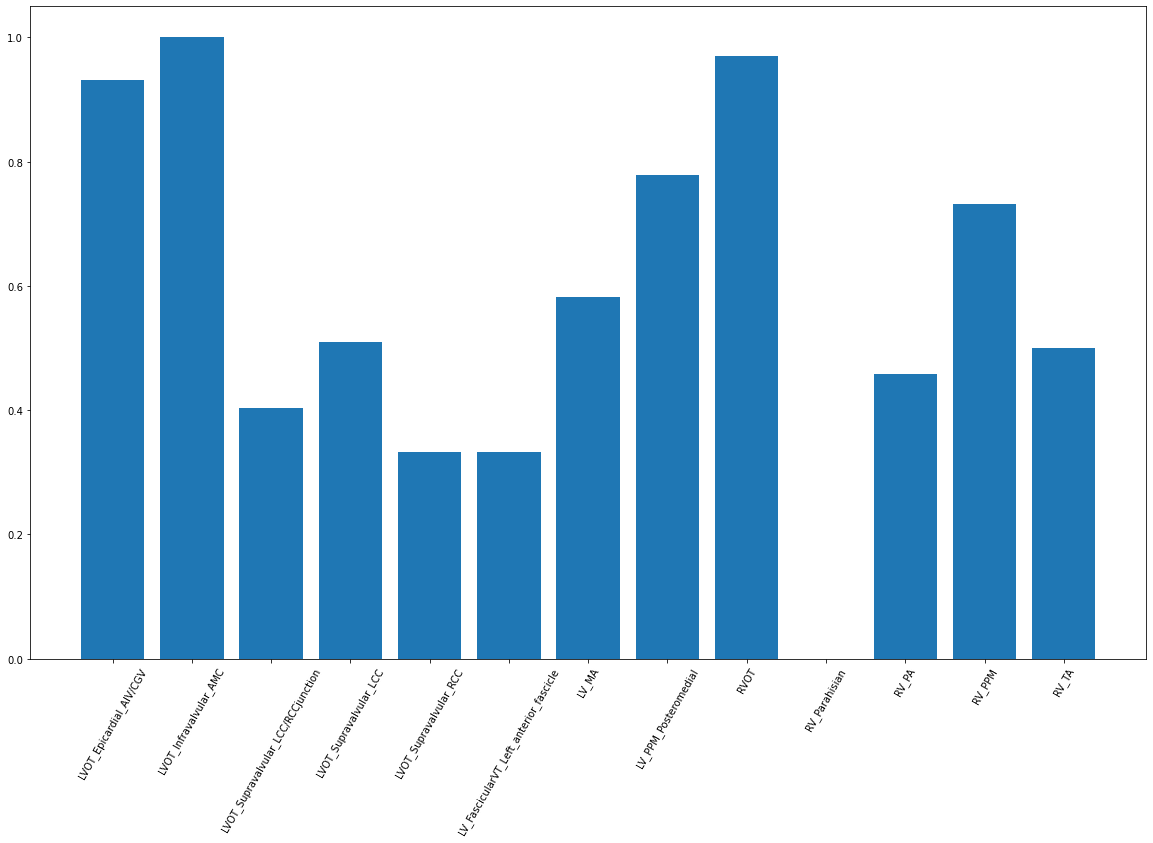

In [174]:
#plot accuracy across different location
threshould = 0.5
dic_total = {}
dic_correct = {}
dic_correct_rate = {}
for i in range(len(collect_ecg)):
    ori_location = collect_ecg[i][2]
    location = dic_2TPE[ori_location]
    label = collect_ecg[i][3]
    output = collect_ecg[i][4]
    if location in dic_total:
        dic_total[location] +=1
        if abs(label-output)<0.5:
            dic_correct[location]+=1
    else:  
        #initialiazation
        dic_correct_rate[location] = 0
        dic_total[location] = 0
        dic_correct[location] = 0
        #count the number
        dic_total[location] +=1
        if abs(label-output)<0.5:
            dic_correct[location]+=1
for location in dic_correct_rate:
    dic_correct_rate[location] = dic_correct[location]/dic_total[location]

print(dic_total)
print(dic_correct_rate)
plt.figure(figsize = (20,12))
plt.xticks(rotation = 60 )
plt.bar(dic_correct_rate.keys(),dic_correct_rate.values())

In [240]:
#use all wave
num_correct = 0
num_total = 0
#list to collecting result for ROC curve
collect_ecg = [] 
target=[]
predictions=[]
locations=[]
#count wave number distribution
count_LR=[0,0]
model.eval()
for i in range(len(test_data_loader)):
    list_ecg, list_label, location, file_name = test_data_loader[i]
    for k in range(len(list_ecg)):
        label = list_label[k].item()
        num_total+=1
        ecg = list_ecg[k]
        ecg = ecg[None,:,:,:]
        output = model(ecg.cuda())
        ecg = ecg[0,0,:,:]
        target.append(list_label[k].item())
        predictions.append(output.item()) #make prediction
        locations.append(location)
        #count wave type, L't or R't
        count_LR[label]+=1
        print(location , label-output.item())
        collect_ecg .append((ecg,file_name,location, label, output.item())) 

LVOT_Epicardial_AIV/CGV -0.14569883048534393
LVOT_Epicardial_AIV/CGV -0.16466404497623444
LVOT_Epicardial_AIV/CGV -0.061994969844818115
LVOT_Epicardial_AIV/CGV -0.10364401340484619
LVOT_Epicardial_AIV/CGV -0.05003739893436432
LVOT_Epicardial_AIV/CGV -0.09947134554386139
LVOT_Epicardial_AIV/CGV -0.04293731600046158
LVOT_Epicardial_AIV/CGV -0.05279812216758728
LVOT_Epicardial_AIV/CGV -0.05694585293531418
LVOT_Epicardial_AIV/CGV -0.11150814592838287
LVOT_Epicardial_AIV/CGV -0.07238755375146866
LVOT_Epicardial_AIV/CGV -0.060605913400650024
LVOT_Epicardial_AIV/CGV -0.4036659896373749
LVOT_Epicardial_AIV/CGV -0.09658342599868774
LVOT_Epicardial_AIV/CGV -0.1502148061990738
LVOT_Epicardial_AIV/CGV -0.12304288148880005
LVOT_Epicardial_AIV/CGV -0.158680722117424
LVOT_Epicardial_AIV/CGV -0.21088099479675293
LVOT_Epicardial_AIV/CGV -0.09755294024944305
LVOT_Epicardial_AIV/CGV -0.060092438012361526
LVOT_Epicardial_AIV/CGV -0.07183382660150528
LVOT_Epicardial_AIV/CGV -0.4760613739490509
LVOT_Epicard

LVOT_Supravalvular_LCC -0.4618059992790222
LVOT_Supravalvular_LCC -0.4736658036708832
LVOT_Supravalvular_LCC -0.5404581427574158
LVOT_Supravalvular_LCC -0.6002106666564941
LVOT_Supravalvular_LCC -0.596523642539978
LVOT_Supravalvular_LCC -0.8460882306098938
LVOT_Supravalvular_LCC -0.6889551877975464
LVOT_Supravalvular_LCC -0.9077354073524475
LVOT_Supravalvular_LCC -0.9094685912132263
LVOT_Supravalvular_LCC -0.8167039752006531
LVOT_Supravalvular_LCC -0.7573595643043518
LVOT_Supravalvular_LCC -0.9278170466423035
LVOT_Supravalvular_LCC -0.7848307490348816
LVOT_Supravalvular_LCC -0.9575002789497375
LVOT_Supravalvular_LCC -0.8953118324279785
LVOT_Supravalvular_LCC -0.5745291709899902
LVOT_Supravalvular_LCC -0.7135045528411865
LVOT_Supravalvular_LCC -0.7796927690505981
LVOT_Supravalvular_LCC -0.9189053773880005
LVOT_Supravalvular_LCC -0.1348651796579361
LVOT_Supravalvular_LCC -0.09348458051681519
LVOT_Supravalvular_LCC -0.09501971304416656
LVOT_Supravalvular_LCC -0.08813085407018661
LVOT_Supr

RV_TA 0.04018700122833252
RV_TA 0.010878145694732666


In [177]:
data = {}
for i , location in enumerate(locations):
    if location in data:
        data[location].append(predictions[i])
    else:  
        #initialiazation
        data[location] = []
        data[location].append(predictions[i])

LVOT_Epicardial_AIV/CGV
LVOT_Infravalvular_AMC
LVOT_Supravalvular_LCC/RCCjunction
LVOT_Supravalvular_LCC
LVOT_Supravalvular_RCC
LV_FascicularVT_Left_anterior_fascicle
LV_MA
LV_PPM_Posteromedial
RVOT
RV_Parahisian
RV_PA
RV_PPM
RV_TA


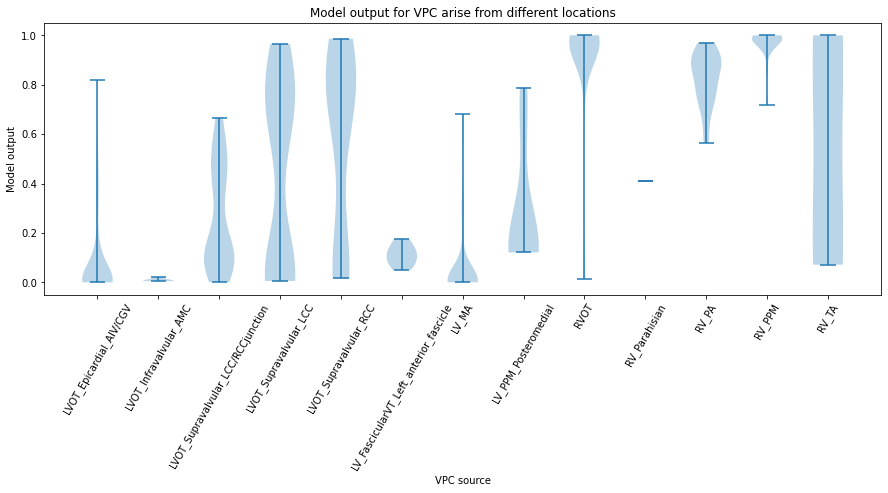

In [276]:
input_data = []
for key in data:
    print(key)
    input_data.append(data[key])
plt.figure(figsize=(15,5))
plt.violinplot(input_data)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13], ['LVOT_Epicardial_AIV/CGV', 'LVOT_Infravalvular_AMC', 'LVOT_Supravalvular_LCC/RCCjunction', 'LVOT_Supravalvular_LCC', 'LVOT_Supravalvular_RCC', 'LV_FascicularVT_Left_anterior_fascicle', 'LV_MA', 'LV_PPM_Posteromedial', 'RVOT', 'RV_Parahisian', 'RV_PA', 'RV_PPM', 'RV_TA'])
plt.xticks(rotation = 60 )
plt.title('Model output for VPC arise from different locations')
plt.xlabel('VPC source')
plt.ylabel('Model output')
plt.show()

In [203]:
data = {}
data['summit'] = []
data['cusp'] = []
data['Left chamber'] = []
data['RVOT'] = []
data['Right chamber'] = []
for i , location in enumerate(locations):
    if location == 'LVOT_Epicardial_AIV/CGV':
        data['summit'].append(predictions[i])
    elif (location == 'LVOT_Supravalvular_LCC/RCCjunction')| (location == 'LVOT_Supravalvular_LCC') | (location == 'LVOT_Supravalvular_NCC') | (location == 'LVOT_Supravalvular_RCC'):
        data['cusp'].append(predictions[i])
    elif (location == 'LVOT_Infravalvular_AMC')|(location == 'LV_FascicularVT_Left_anterior_fascicle')|(location == 'LV_MA')|(location == 'LV_PPM_Posteromedial'):
        data['Left chamber'].append(predictions[i])
    elif location == 'RVOT':
        data['RVOT'].append(predictions[i])
    elif (location == 'RV_Parahisian')|(location == 'RV_PA')|(location == 'RV_PPM')|(location == 'RV_TA'):
        data['Right chamber'].append(predictions[i])

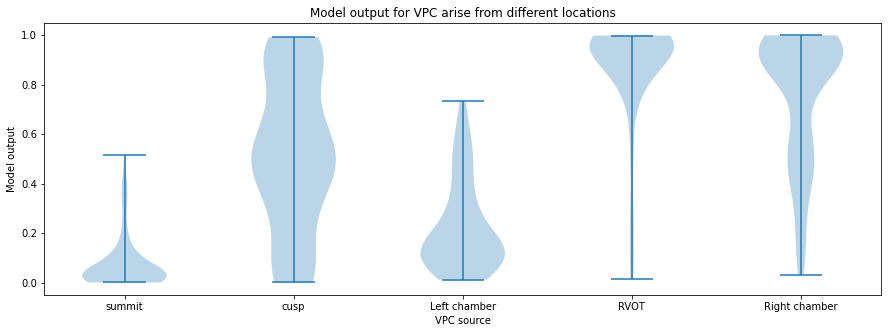

In [204]:
input_data = []
for key in data:
    input_data.append(data[key])
plt.figure(figsize=(15,5))
plt.violinplot(input_data)
plt.xticks([1,2,3,4,5], ['summit','cusp','Left chamber','RVOT','Right chamber'])
plt.title('Model output for VPC arise from different locations')
plt.xlabel('VPC source')
plt.ylabel('Model output')
plt.show()

### ROC plot

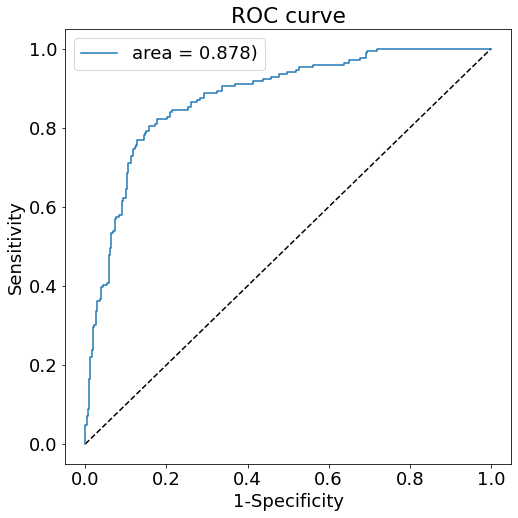

In [260]:
#view ROC curve, referance: https://www.dlology.com/blog/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier/
from sklearn.metrics import roc_curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve(target, predictions)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(figsize=(8,8))
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='area = {:.3f})'.format(auc_keras))
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# Plot datasize vs accuracy

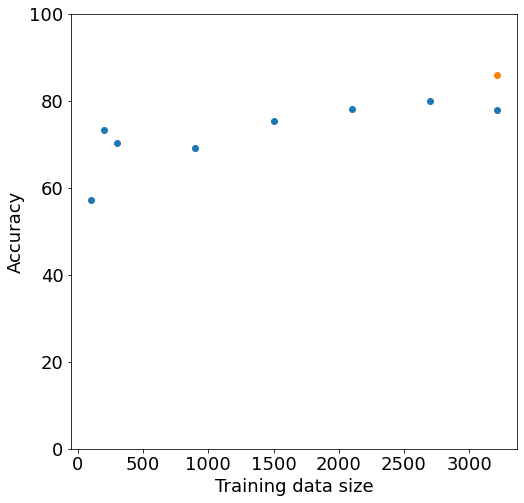

In [233]:
datasize=[100,200,300,900,1500,2100,2700,3211]
accuracy=[57.2,73.2,70.3,69.2,75.3,78.2,80.0,77.8]
plt.rcParams.update({'font.size': 18,'font.weight':'light', 'font.style':'normal'})
plt.figure(figsize=(8,8))
plt.scatter(datasize,accuracy)
plt.scatter([3211],[85.9])
plt.ylim([0,100])
plt.xlabel('Training data size')
plt.ylabel('Accuracy')
plt.show()

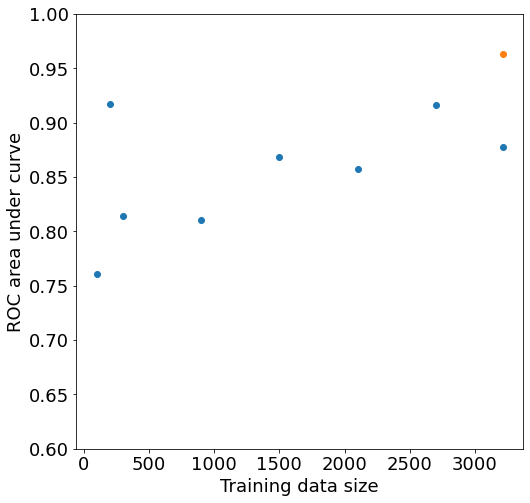

In [266]:
datasize=[100,200,300,900,1500,2100,2700,3211]
accuracy=[0.761,0.917,0.814,0.810,0.868,0.857,0.916,0.878]
plt.rcParams.update({'font.size': 18,'font.weight':'light', 'font.style':'normal'})
plt.figure(figsize=(8,8))
plt.scatter(datasize,accuracy)
plt.scatter([3211],[0.963])
plt.ylim([0.6,1])
plt.xlabel('Training data size')
plt.ylabel('ROC area under curve')
plt.show()